# Information Loss During Size Reduction Depending On Structure Scale

In this _Jupyter Notebook_, we will reduce the size of datasets representing _Gaussian Random Fields_ using various techniques and investigate how much information is lost. These techniques can be useful when the original dataset is very large and performing analyses on it is costly.

## Initialisation

We start by setting up the necessary tools.

### Imports

The following modules are required in this _Jupyter Notebook_.

In [1]:
import logging
import gc
import math
import numpy
import datetime
import sys
import scipy
import scipy.linalg
import scipy.stats
import scipy.ndimage
import matplotlib.pyplot
import copy
import pysal
import rasterio

### Logging

Turning on logging.

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
consoleHandler = logging.StreamHandler()
consoleHandler.setFormatter(formatter)
logger.addHandler(consoleHandler)

## Functions

The following functions will be used throughout this _Jupyter Notebook_.

### Helper Functions

The _loop_ function runs the function given as the first argument multiple times, until the uncertainty in the mean of the results of that function is below a certain threshold.

In [3]:
def loop(function, args={}):
    results = [function(**args) for i in range(5)]
    while numpy.amax(numpy.std(results, axis=0)) / len(results) > 0.01 and len(results) < 100:
        results.append(function(**args))
    logger.info("Needed " + str(len(results)) + " iterations to converge.")
    return numpy.mean(results, axis=0)

The _reduceUSV_ function takes the output of an _SVD_ and removes the smallest _singular values_.

In [4]:
def reduceUSV(U, s, Vt, p):
    U = U[:, :p]
    s = s[:p]
    Vt = Vt[:p]
    return U, s, Vt

The _usvToMatrix_ function takes the output of an _SVD_ and reconstructs the original matrix.

In [5]:
def usvToMatrix(U, s, Vt):
    return U @ numpy.diag(s) @ Vt

The _usvToReducedMatrix_ function combines the previous two functions by reconstructing the original matrix, except for the smallest _singular values_.

In [6]:
def usvToReducedMatrix(U, s, Vt, p):
    U, s, Vt = reduceUSV(U, s, Vt, p)
    return usvToMatrix(U, s, Vt)

The _reduceMatrix_ function performs an _SVD_ on the input matrix, reduces its dimensionality and then reconstructs the matrix.

In [7]:
def reduceMatrix(A, p):
    U, s, Vt = scipy.linalg.svd(A, full_matrices = False)
    return usvToReducedMatrix(U, s, Vt, p)

The _centerAndStandardiseField_ function centers and standardises the input matrix by row.

In [8]:
def centerAndStandardiseField(matrix):
    return (matrix - numpy.mean(matrix, axis=1)[:, None]) / numpy.std(matrix, axis=1)[:, None]

The _flattenSpatialTemporalFields_ function reshapes a two 3D matrices into two 2D matrices.

In [9]:
def flattenSpatialTemporalFields(matrix1, matrix2):
    h, w, d = matrix1.shape
    result1 = matrix1.reshape(h * w, d)
    h, w, d = matrix2.shape
    result2 = matrix2.reshape(h * w, d)
    return result1, result2

The _splitSpatialTemporalField_ function splits a 3D matrix into two 3D matrices by taking alternating slices in the third dimension.

In [10]:
def splitSpatialTemporalField(matrixCombined):
    h, w, d = matrixCombined.shape
    d1 = numpy.arange(0, d, 2)
    d2 = numpy.arange(1, d, 2)
    matrix1 = matrixCombined[:, :, d1]
    matrix2 = matrixCombined[:, :, d2]
    return matrix1, matrix2

The _splitAndFlattenSpatialTemporalField_ function combines the previous two functions.

In [11]:
def splitAndFlattenSpatialTemporalField(matrixCombined):
    matrix1, matrix2 = splitSpatialTemporalField(matrixCombined)
    matrixFlattened1, matrixFlattened2 = flattenSpatialTemporalFields(matrix1, matrix2)
    return matrixFlattened1, matrixFlattened2

In [12]:
def addRectangle(axis, left, top, width, height, text, type=None):
    right = left + width
    bottom = top - height
    patch = matplotlib.patches.Rectangle(
        (left, bottom), width, height,
        fill=False, clip_on=False
        )
    axis.add_patch(patch)
    axis.text(0.5*(left+right), 0.5*(bottom+top), text,
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=14)
    left = right + 0.1
    return axis, left

In [13]:
def addSymbol(axis, left, top, symbol, type=None):
    axis.text(left + 0.1,
              top - 0.15, symbol,
              horizontalalignment='center',
              verticalalignment='center',
              fontsize=14)
    left = left + 0.3
    return axis, left

In [14]:
def plotMatrixMultiplication(matrixDescription=[{}], filePath=None):
    h, w = 0.1, 0.1
    for args in matrixDescription:
        if args["type"] is "Matrix":
            h = max(h, args["height"] + 0.2)
            w = w + args["width"] + 0.1
        elif args["type"] is "Symbol":
            w = w + 0.3
    figure, axis = matplotlib.pyplot.subplots()
    matplotlib.pyplot.axis('off')
    axis.set_aspect('equal')
    axis.set_xlim(0, w)
    axis.set_ylim(0, h)
    figure.set_size_inches(1.4 * w, 1.4 * h)
    left, top = 0.1, h - 0.1
    for args in matrixDescription:
        if args["type"] is "Matrix":
            axis, left = addRectangle(axis, left, top, **args)
        elif args["type"] is "Symbol":
            axis, left = addSymbol(axis, left, top, **args)
    if filePath is not None:
        matplotlib.pyplot.savefig(filePath, bbox_inches='tight')
    matplotlib.pyplot.show()

### Gaussian Random Spatial Field

The _gaussianRandomSpatialField_ function generates a 2D matrix representing a _Gaussian Random Field_ where the power spectrum follows a power law with exponent α. The resulting matrix is scaled such that it has zero mean and unit standard deviation.

In [15]:
def gaussianRandomSpatialField(alpha=-2.0, size=100):
    # Based on: http://andrewwalker.github.io/statefultransitions/post/gaussian-fields/
    noise = numpy.fft.fft2(numpy.random.normal(size=(size, size)))
    mesh = numpy.meshgrid(range(-size//2, size//2), range(-size//2, size//2))
    distance = numpy.power(mesh[0], 2, dtype=numpy.float64) + numpy.power(mesh[1], 2, dtype=numpy.float64)
    distance[size//2, size//2] = numpy.inf
    amplitude = numpy.power(distance, alpha/2)
    amplitude = numpy.fft.ifftshift(amplitude)
    result = numpy.fft.ifft2(noise * amplitude).real
    result = (result - numpy.mean(result)) / numpy.std(result)
    return result

The _singular values_ of a matrix represent the amount of variance in the original dataset explained by the associated singular vector. The _explainedVariance_ function takes the list of _singular values_ and returns a list of explained variance. This can e.g. be used in a plot.

In [16]:
def explainedVariance(s):
    x = numpy.arange(1, len(s) + 1)
    total = s.T @ s
    cumulativeValue = 0
    valueList = numpy.square(s) / total
    cumulativeList = numpy.cumsum(valueList)
    mask = valueList > 0.005
    x = x[mask]
    valueList = valueList[mask]
    cumulativeList = cumulativeList[mask]
    return x, valueList, cumulativeList

The _getGaussianPowerSpectrum_ function takes a 2D matrix, assumes it represents a rotationally invariant _Gaussian Random Field_ and return the power spectrum of the field.

In [17]:
def getGaussianPowerSpectrum(dataArray):
    if len(dataArray.shape) == 3:
        h, w, d = dataArray.shape
        mesh = numpy.meshgrid(range(-h//2, h//2), range(-w//2, w//2), range(-d//2, d//2))
        wavesFlattened = (numpy.power(mesh[0], 2) + numpy.power(mesh[1], 2) + numpy.power(mesh[2], 2)).flatten()
    else:
        h, w = dataArray.shape
        mesh = numpy.meshgrid(range(-h//2, h//2), range(-w//2, w//2))
        wavesFlattened = numpy.power(numpy.power(mesh[0], 2) + numpy.power(mesh[1], 2), 1/2).flatten()
    fft = numpy.fft.fftn(dataArray)
    fftShifted = numpy.fft.fftshift(fft)
    fftAbs = numpy.abs(fftShifted)
    fftFlattened = fftAbs.flatten()
    mask = wavesFlattened == 0
    wavesMasked = wavesFlattened[~mask]
    fftMasked = fftFlattened[~mask]
    mask2 = numpy.log(fftMasked) < -20
    wavesMasked2 = wavesMasked[~mask2]
    fftMasked2 = fftMasked[~mask2]
    return wavesMasked2, fftMasked2

The _estimateGaussianPowerLaw_ function takes a 2D matrix, assumes it represents a rotationally invariant _Gaussian Random Field_ and estimates the exponent of the power law which fits the power spectrum of the field.

In [18]:
def estimateGaussianPowerLaw(dataArray, wavesMasked=None, fftMasked=None):
    if wavesMasked is None or fftMasked is None:
        wavesMasked, fftMasked = getGaussianPowerSpectrum(dataArray)
    wavesLog = numpy.log(wavesMasked)
    fftLog = numpy.log(fftMasked)
    estimatedAlpha, estimatedIntercept, r_value, p_value, std_err = scipy.stats.linregress(wavesLog, fftLog)
    estimatedRSquared = r_value**2
    return estimatedAlpha, estimatedIntercept, estimatedRSquared

The _estimateSingularValuesPowerLaw_ function takes a 2D matrix, assumes its singular values fit a power law and estimates the exponent of the power law.

In [19]:
def estimateSingularValuesPowerLaw(singularValues):
    x = numpy.log(list(range(1, len(singularValues) + 1)))
    y = numpy.log(singularValues)
    mask = y < -20
    x = x[~mask]
    y = y[~mask]
    estimatedBeta, estimatedIntercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    estimatedBetaRSquared = r_value**2
    return estimatedBeta, estimatedIntercept, estimatedBetaRSquared

Let's plot some _Gaussian Random Fields_ of various sizes, for various α's. Let's also test the _estimateGaussianPowerLaw_ function by applying it to the generated datasets and comparing the result with the true α. As can be seen, the α is a measure of the spatial autocorrelation of the field. In particular, fields with large scale structure have a more negative α. Additionally, the size of the _singular values_ can be plotted. This is related to the power spectrum and will also provide information about the scale of the structure in the field. Finally, there are other measures of spatial autocorrelation. These include the Gamma Index and Moran's I. The Python module _pysal_ contains functions to calculate these values. We will include them for each plot.

Size: 100 | Alpha: -1.000
Estimated Alpha: -0.999 | r^2: 0.380
Estimated Beta: -1.271 | r^2: 0.992
g.g: 3.096 | g.p_sim_g: 0.001
mi.I: 0.789 | mi.p_rand: 0.000


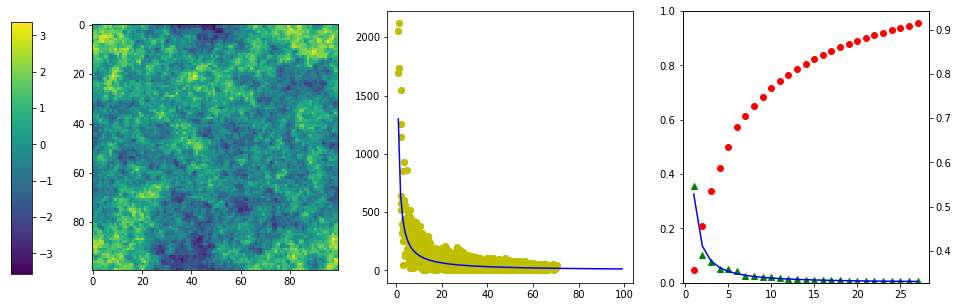

Size: 100 | Alpha: -2.000
Estimated Alpha: -2.005 | r^2: 0.718
Estimated Beta: -2.807 | r^2: 0.991
g.g: 3.942 | g.p_sim_g: 0.001
mi.I: 0.996 | mi.p_rand: 0.000


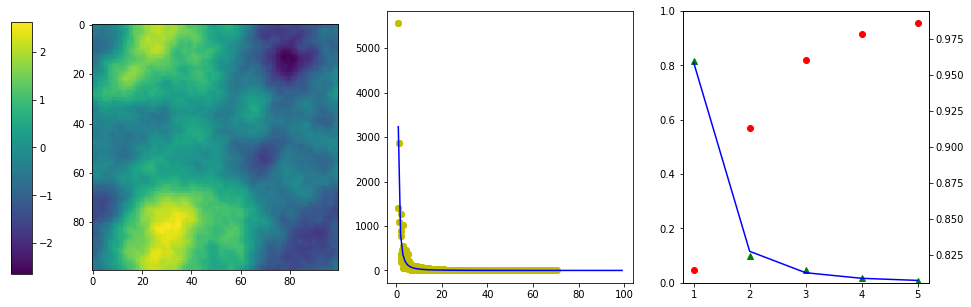

Size: 100 | Alpha: -4.000
Estimated Alpha: -4.019 | r^2: 0.909
Estimated Beta: -1.185 | r^2: 0.739
g.g: 3.966 | g.p_sim_g: 0.001
mi.I: 0.999 | mi.p_rand: 0.000


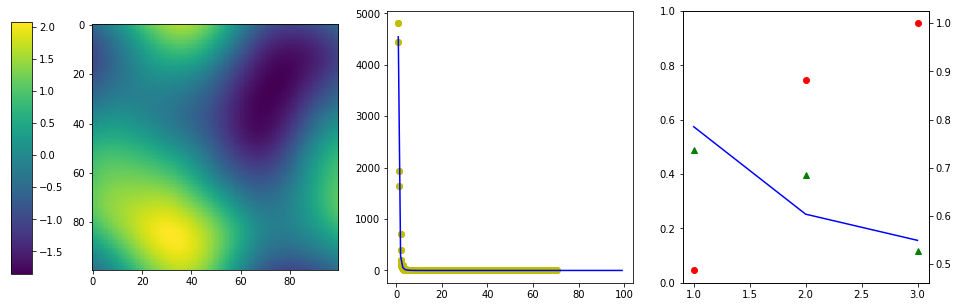

Size: 200 | Alpha: -1.000
Estimated Alpha: -1.002 | r^2: 0.390
Estimated Beta: -1.092 | r^2: 0.989
g.g: 3.063 | g.p_sim_g: 0.001
mi.I: 0.769 | mi.p_rand: 0.000


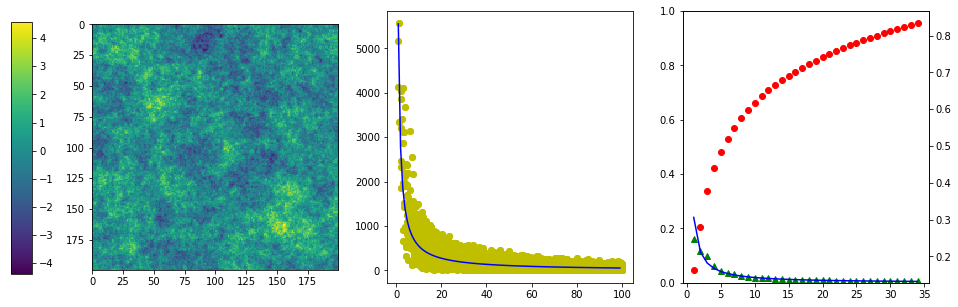

Size: 200 | Alpha: -2.000
Estimated Alpha: -2.007 | r^2: 0.714
Estimated Beta: -2.524 | r^2: 0.973
g.g: 3.968 | g.p_sim_g: 0.001
mi.I: 0.998 | mi.p_rand: 0.000


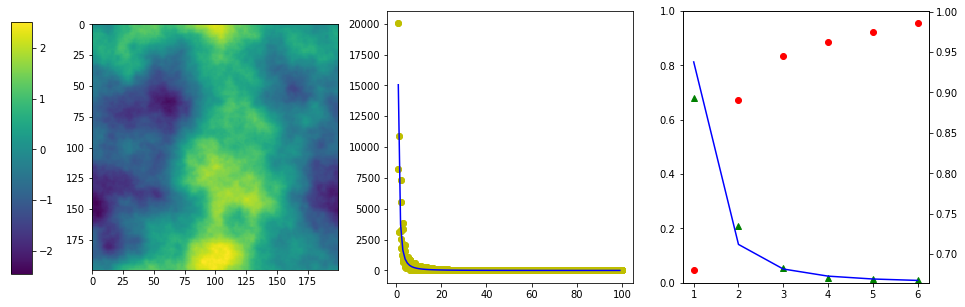

Size: 200 | Alpha: -4.000
Estimated Alpha: -3.996 | r^2: 0.911
Estimated Beta: -1.492 | r^2: 1.000
g.g: 3.973 | g.p_sim_g: 0.001
mi.I: 1.000 | mi.p_rand: 0.000


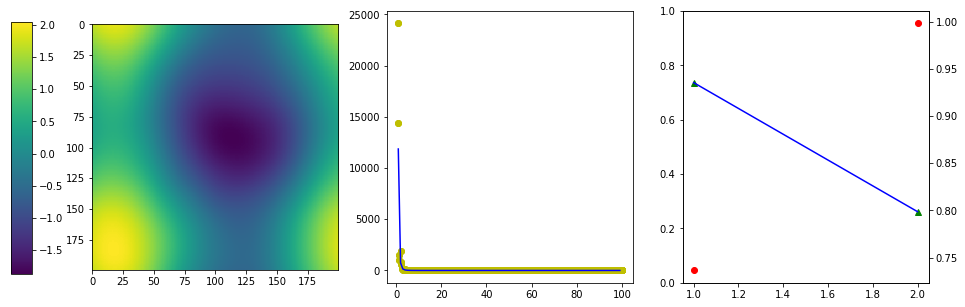

Size: 400 | Alpha: -1.000
Estimated Alpha: -1.000 | r^2: 0.390
Estimated Beta: -1.100 | r^2: 0.996
g.g: 3.277 | g.p_sim_g: 0.001
mi.I: 0.821 | mi.p_rand: 0.000


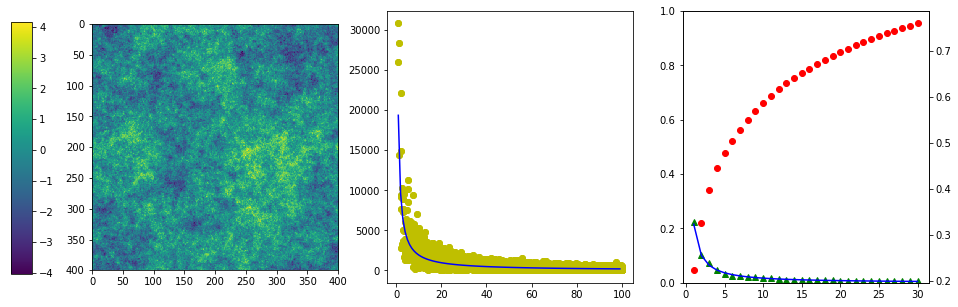

Size: 400 | Alpha: -2.000
Estimated Alpha: -1.999 | r^2: 0.719
Estimated Beta: -3.041 | r^2: 0.981
g.g: 3.984 | g.p_sim_g: 0.001
mi.I: 1.000 | mi.p_rand: 0.000


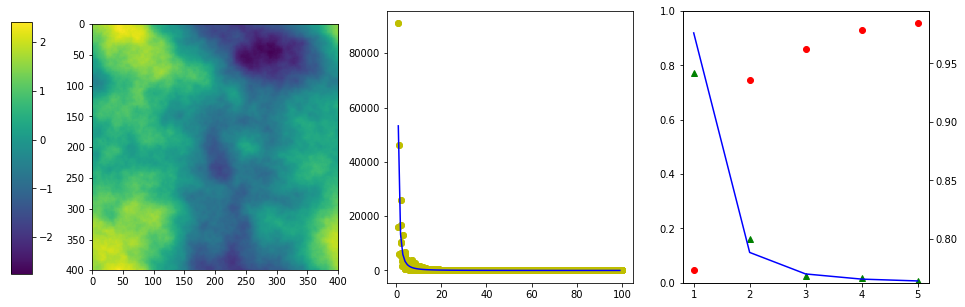

Size: 400 | Alpha: -4.000
Estimated Alpha: -4.010 | r^2: 0.912
Estimated Beta: -3.006 | r^2: 0.699
g.g: 3.987 | g.p_sim_g: 0.001
mi.I: 1.000 | mi.p_rand: 0.000


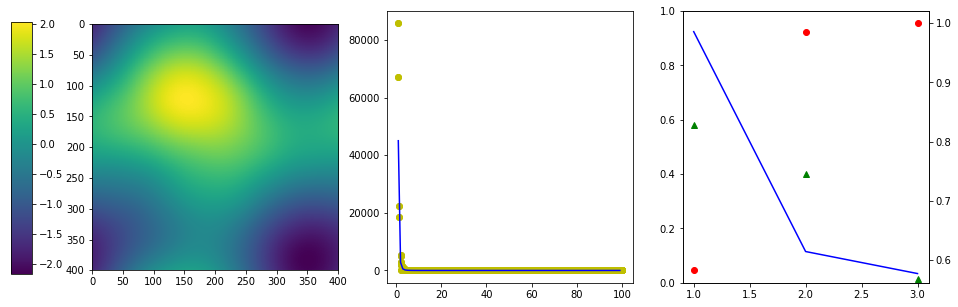

In [20]:
for size in [100, 200, 400]:
    for alpha in [-1, -2, -4]:
        data = gaussianRandomSpatialField(alpha, size)
        wavesMasked, fftMasked = getGaussianPowerSpectrum(data)
        estimatedAlpha, estimatedIntercept, estimatedRSquared = estimateGaussianPowerLaw(data, wavesMasked, fftMasked)
        U, s, Vt = scipy.linalg.svd(data, full_matrices = False)
        x, valueList, cumulativeList = explainedVariance(s)
        estimatedBeta, estimatedBetaIntercept, estimatedBetaRSquared = estimateSingularValuesPowerLaw(valueList)
        y = data.flatten()
        w = pysal.lat2W(size, size)
        g = pysal.Gamma(y, w)
        mi = pysal.Moran(y, w)
        print("Size: {:d} | Alpha: {:0.3f}".format(size, alpha))
        print("Estimated Alpha: {:0.3f} | r^2: {:0.3f}".format(estimatedAlpha, estimatedRSquared))
        print("Estimated Beta: {:0.3f} | r^2: {:0.3f}".format(estimatedBeta, estimatedBetaRSquared))
        print("g.g: {:0.3f} | g.p_sim_g: {:0.3f}".format(g.g/size**2, g.p_sim_g))
        print("mi.I: {:0.3f} | mi.p_rand: {:0.3f}".format(mi.I, mi.p_rand))
        fig, (ax1, ax2, ax3) = matplotlib.pyplot.subplots(1, 3, figsize=(15, 5))
        im = ax1.imshow(data)
        cbaxes = fig.add_axes([0.05, 0.15, 0.02, 0.7])
        fig.colorbar(im, cax = cbaxes)
        ax2.plot(wavesMasked[wavesMasked<100], fftMasked[wavesMasked<100], "yo")
        ax2.plot(range(1, 100), math.exp(estimatedIntercept) * numpy.power(range(1, 100), estimatedAlpha), "b-")
        ax3.plot(x, valueList, "g^")
        ax3.plot(x, math.exp(estimatedBetaIntercept) * numpy.power(x, estimatedBeta), "b-")
        ax3.set_ylim(0, valueList[0])
        ax3b = ax3.twinx()
        ax3.set_ylim(0, 1)
        ax3b.plot(x, cumulativeList, "ro")
        matplotlib.pyplot.show()

To find a more precise relation between the α of a _Gaussian Random Fields_ and the other measures of spatial autocorrelation, let's generate various fields for different sizes and different α's. We can then calculate the Gamma Index and Moran's I as a function of α.

In [21]:
def testGammaAndMoransI(size=200, alpha=-2):
    data = gaussianRandomSpatialField(alpha, size)
    y = data.flatten()
    w = pysal.lat2W(size, size)
    g = pysal.Gamma(y, w)
    mi = pysal.Moran(y, w)
    return g.g/size**2, mi.I

The following two numbers are the Gamma Index, divided by the size of the matrix, and Moran's I. By varying the size and the α, we can find their dependency on these parameters.

In [22]:
loop(testGammaAndMoransI)

2018-02-15 17:54:37,743 - INFO - Needed 5 iterations to converge.


array([ 3.97435655,  0.99892522])

As expected, it seems a smaller matrix size does not result in any relevant changes in the Gamma Index nor in Moran's I.

In [23]:
loop(testGammaAndMoransI, {"size": 100})

2018-02-15 17:54:40,837 - INFO - Needed 5 iterations to converge.


array([ 3.94154914,  0.9956524 ])

We can conclude that these measures are, above a minimum size, independent of size.

In [24]:
loop(testGammaAndMoransI, {"size": 400})

2018-02-15 17:55:48,256 - INFO - Needed 5 iterations to converge.


array([ 3.98498365,  0.99951733])

When α is less negative, the _Gaussian Random Field_ has smaller scale structure. It is closer to randomness and has less autocorrelation. As expected, this can be seen in the two measures of autocorrelation, which are now smaller.

In [25]:
loop(testGammaAndMoransI, {"alpha": -1})

2018-02-15 17:56:13,031 - INFO - Needed 10 iterations to converge.


array([ 3.11197741,  0.78186043])

Similarly, a more negative α results in larger values for the two measures of autocorrelation.

In [26]:
loop(testGammaAndMoransI, {"alpha": -4})

2018-02-15 17:56:25,346 - INFO - Needed 5 iterations to converge.


array([ 3.97691293,  0.99971457])

We can also plot the relation between α, the Gamma Index weighted by size and Moran's I.

In [27]:
def plotGammaAndMoransI(size=200):
    alphas = numpy.arange(-0.25, -3.1, -0.25)
    line = []
    line2 = []
    for alpha in alphas:
        value = loop(testGammaAndMoransI, {"size": size, "alpha": alpha})
        line.append(value[0])
        line2.append(value[1])
    matplotlib.pyplot.plot(alphas, line)
    matplotlib.pyplot.plot(alphas, line2)
    matplotlib.pyplot.legend(["Γ per size", "Moran's I"])
    matplotlib.pyplot.xlabel("α")
    matplotlib.pyplot.ylabel("value")
    matplotlib.pyplot.savefig("Results/plotGammaAndMoransI.pdf")
    matplotlib.pyplot.show()

The plot below indeed shows negative correlation of α and with the Gamma Index and with Moran's I. Subsequent analyses will define the scale of the field's structure in terms of α. This plot can help _translate_ this measure to the other two measures of autocorrelation.

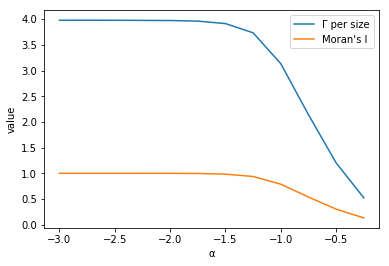

In [28]:
logger.disabled = True
plotGammaAndMoransI()
logger.disabled = False

In [29]:
_ = gc.collect()

### Gaussian Random Spatial-Temporal Field

In many real-world applications, the analysis of a field does not only involve a single _time snapshot_. In fact, it often includes data over multiple weeks, months or years, where the field over the entire time period does not change drastically. Just as there is spatial autocorrelation, there is temporal autocorrelation. The _gaussianRandomSpatialTemporalField_ function generates a 3D matrix where the third dimension represent _time_. In principle, there can be a different level of correlation over time than over space. However, for simplicity, we are using the same α determine the level of autocorrelation in all dimensions.

In [30]:
def gaussianRandomSpatialTemporalField(alpha=-2.0, spatialSize=100, temporalSize=40):
    noise = numpy.fft.fftn(numpy.random.normal(size=(spatialSize, spatialSize, temporalSize)))
    mesh = numpy.meshgrid(range(-spatialSize//2, spatialSize//2), range(-spatialSize//2, spatialSize//2), range(-temporalSize//2, temporalSize//2))
    distance = numpy.power(mesh[0], 2, dtype=numpy.float64) + numpy.power(mesh[1], 2, dtype=numpy.float64) + numpy.power(mesh[2], 2, dtype=numpy.float64)
    distance[spatialSize//2, spatialSize//2, temporalSize//2] = numpy.inf
    amplitude = numpy.power(distance, alpha/2)
    amplitude = numpy.fft.ifftshift(amplitude)
    result = numpy.fft.ifftn(noise * amplitude).real
    result = (result - numpy.mean(result)) / numpy.std(result)
    return result

We can plot various _time snapshots_ of a spatial field next to each other, which will show how the field evolves in time. These changes will occur rapidly for less negative α and slower for more negative α. The _estimateGaussianPowerLaw_ function can, again, be used to estimate α a posteriori.

Spatial Size: 100 | Alpha: -1.000
Estimated Alpha: -0.496 | r^2: 0.380


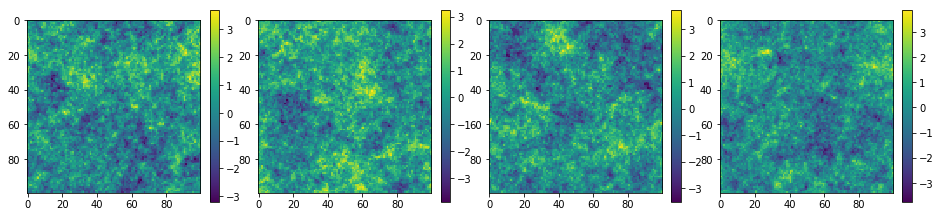

Spatial Size: 100 | Alpha: -2.000
Estimated Alpha: -0.993 | r^2: 0.709


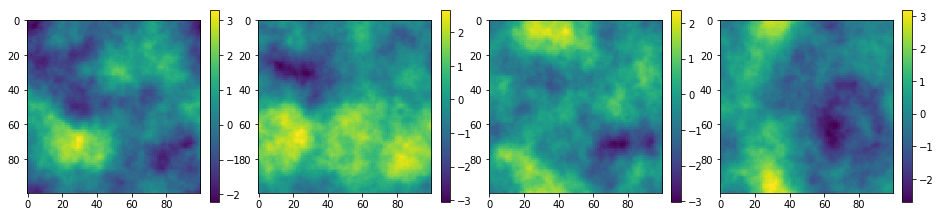

Spatial Size: 100 | Alpha: -4.000
Estimated Alpha: -2.001 | r^2: 0.907


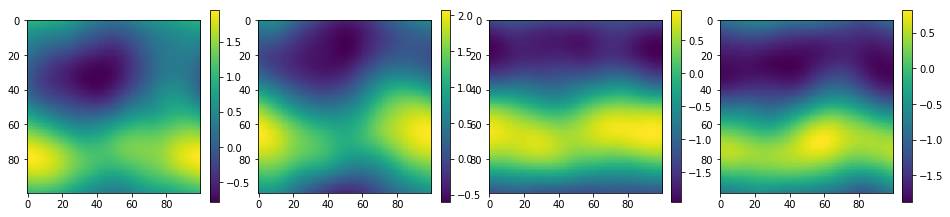

Spatial Size: 200 | Alpha: -1.000
Estimated Alpha: -0.500 | r^2: 0.386


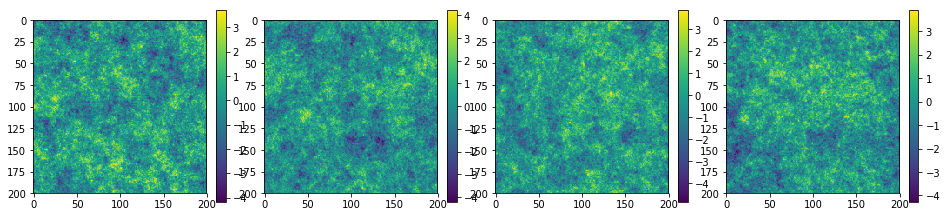

Spatial Size: 200 | Alpha: -2.000
Estimated Alpha: -0.996 | r^2: 0.715


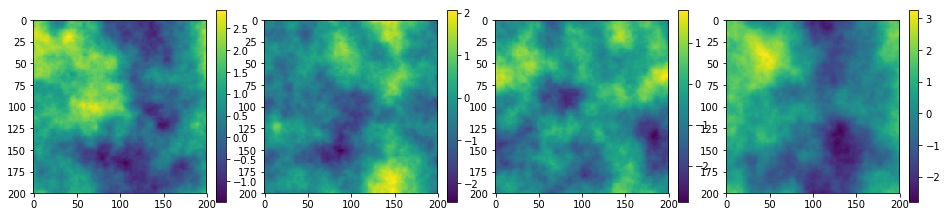

Spatial Size: 200 | Alpha: -4.000
Estimated Alpha: -2.001 | r^2: 0.909


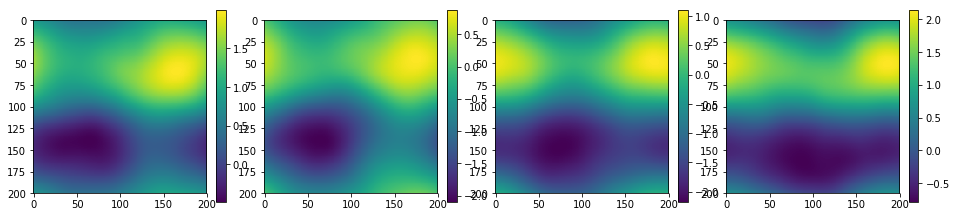

Spatial Size: 400 | Alpha: -1.000
Estimated Alpha: -0.500 | r^2: 0.388


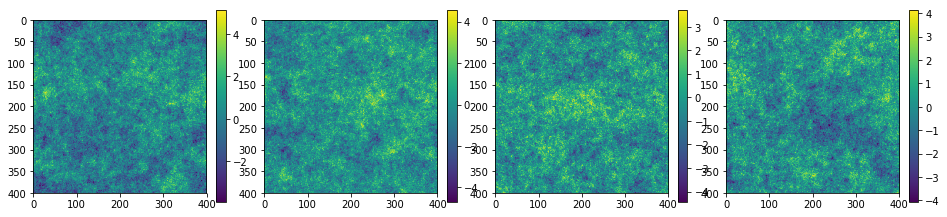

Spatial Size: 400 | Alpha: -2.000
Estimated Alpha: -1.001 | r^2: 0.718


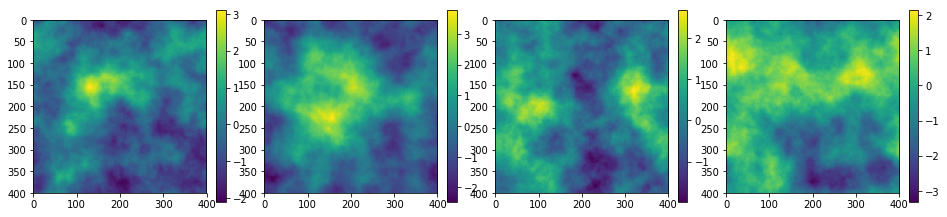

Spatial Size: 400 | Alpha: -4.000
Estimated Alpha: -2.000 | r^2: 0.911


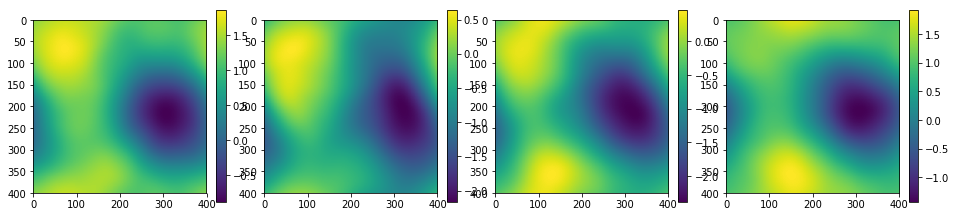

In [31]:
temporalSize=4
for spatialSize in [100, 200, 400]:
    for alpha in [-1, -2, -4]:
        data = gaussianRandomSpatialTemporalField(alpha, spatialSize, temporalSize)
        estimatedAlpha, estimatedIntercept, estimatedRSquared = estimateGaussianPowerLaw(data)
        print("Spatial Size: {:d} | Alpha: {:0.3f}".format(spatialSize, alpha))
        print("Estimated Alpha: {:0.3f} | r^2: {:0.3f}".format(estimatedAlpha, estimatedRSquared))
        matplotlib.pyplot.figure(figsize=(20, 20))
        for i in range(temporalSize):
            matplotlib.pyplot.subplot(1, temporalSize + 1, i + 1)
            matplotlib.pyplot.imshow(data[:, :, i])
            matplotlib.pyplot.colorbar(fraction=0.05)
        matplotlib.pyplot.show()

In [32]:
_ = gc.collect()

## Successful Techniques

This section will discuss four techniques to analyse large datasets efficiently using SVD.

### Efficient Exact Norm Difference via SVD

In real-world application, one often wants to find the norm of the difference between two fields. This can be done by subtracting one matrix from the other and calculating the norm. However, for large matrices, this can be inefficient. Performing an SVD of both matrices can reduce the internal calculations. The _normDifferenceFromUSVs_ function can take such input SVDs and determine the norm of their difference in an efficient manner, provided the number of singular values is small. The result is mathematically identical to the full calculation, which means that any error will be of the order of machine-precision.

In [70]:
def normDifferenceFromUSVs(U1, s1, Vt1, U2, s2, Vt2):
    if U1.shape != U2.shape or s1.shape != s2.shape or Vt1.shape != Vt2.shape:
        print("Error")
        return 0
    AA = s1 @ s1
    BB = s2 @ s2
    AB = s1 @ numpy.multiply(U1.T @ U2, Vt1 @ Vt2.T) @ s2
    return math.sqrt(AA + BB - 2 * AB)

If one is interested in the percentage difference of the second matrix compared with the first, the _percentageNormDifferenceFromUSVs_ function will use the output of the previous function and compare this to the norm of the first matrix, which is simply the sum os its singular values squared.

In [71]:
def percentageNormDifferenceFromUSVs(U1, s1, Vt1, U2, s2, Vt2):
    return normDifferenceFromUSVs(U1, s1, Vt1, U2, s2, Vt2) / math.sqrt(s1 @ s1.T)

The image below shows the equivalence in the calculation of the norm.

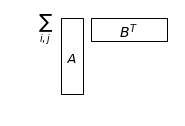

In [72]:
matrixDescription = [
    {"type":"Symbol", "symbol":r"$\sum_{i,j}$"},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$A_{}^{}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$B_{}^{T}$"},
]
plotMatrixMultiplication(matrixDescription, "Results/normDifferenceFromUSVs.pdf")

To verify that the _normDifferenceFromUSVs_ function indeed produces an output identical to the full norm difference, let's generate a _Gaussian Random Field_ and run both types of calculation.

In [73]:
def testNormDifferenceFromUSVs(size=200, alpha=-2):
    matrix1 = gaussianRandomSpatialField(alpha, size)
    matrix2 = gaussianRandomSpatialField(alpha, size)
    matrixDifference = matrix1 - matrix2
    normDifference = scipy.linalg.norm(matrixDifference)
    U1, s1, Vt1 = scipy.linalg.svd(matrix1, full_matrices = False)
    U2, s2, Vt2 = scipy.linalg.svd(matrix2, full_matrices = False)
    normDifference2 = normDifferenceFromUSVs(U1, s1, Vt1, U2, s2, Vt2)
    return numpy.isclose(normDifference, normDifference2)

As expected, the results are identical up to machine-precision.

In [74]:
testNormDifferenceFromUSVs()

True

In [38]:
_ = gc.collect()

### Efficient Exact SVD via QR Decomposition

In real-world application, one often wants to find the relation between two fields. This can be done by performing an SVD of the cross-correlation matrix of these two fields. In particular, the two input datasets often have the various gridpoint as rows and will have the sample of recorded values over time as columns. Multiplying these gives the cross-correlation matrix. However, for highly rectangular matrices, when there are many spatial gridpoint but few temporal samples, the resulting cross-correlation matrix is inefficiently large. The _qrProductSVD_ function can take such input data and perform an SVD in an efficient manner. The result is mathematically identical to the full SVD, which means that the difference will be at machine-precision.

In [39]:
def qrProductSVD(A, B):
    # Based on a suggestion from Mark Tygert during personal communication
    QA, RA = scipy.linalg.qr(A, mode = "economic")
    QB, RB = scipy.linalg.qr(B, mode = "economic")
    C = RA @ RB.T
    UC, s, VCt = scipy.linalg.svd(C, full_matrices = False)
    U = QA @ UC
    Vt = VCt @ QB.T
    return U, s, Vt

The image below shows the equivalence in the calculation of the SVD of the product.

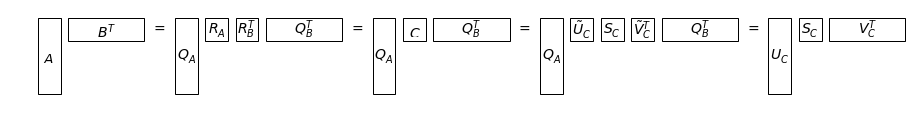

In [40]:
matrixDescription = [
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$A_{}^{}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$B_{}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$Q_{A}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$R_{A}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$R_{B}^{T}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$Q_{B}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$Q_{A}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$C_{}^{}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$Q_{B}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$Q_{A}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$\tilde{U}_{C}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$S_{C}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$\tilde{V}_{C}^{T}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$Q_{B}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$U_{C}^{}}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$S_{C}^{}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$V_{C}^{T}$"},
]
plotMatrixMultiplication(matrixDescription, "Results/qrProductSVD.pdf")

To verify that the _qrProductSVD_ function indeed produces an output identical to the full SVD, let's generate a _Gaussian Random Spatial-Temporal Field_ and run both types of SVD.

In [41]:
def testQRProductSVD(spatialSize=20, temporalSize=10, alpha=-2, p=8):
    matrixBoth = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
    matrix1 = matrixBoth[:, :, :temporalSize]
    matrix2 = matrixBoth[:, :, temporalSize:]
    matrixFlattened1 = matrix1.reshape(spatialSize * spatialSize, temporalSize)
    matrixFlattened2 = matrix2.reshape(spatialSize * spatialSize, temporalSize)
    productMatrix = matrixFlattened1 @ matrixFlattened2.T
    reducedMatrix = reduceMatrix(productMatrix, p)
    U, s, Vt = qrProductSVD(matrixFlattened1, matrixFlattened2)
    U, s, Vt = reduceUSV(U, s, Vt, p)
    reconstructedMatrix = usvToMatrix(U, s, Vt)
    return numpy.allclose(reducedMatrix, reconstructedMatrix)

As expected, the results are identical up to machine-precision.

In [42]:
testQRProductSVD()

True

In [43]:
_ = gc.collect()

### Efficient Approximate SVD via Spatial Coarsening

Although the _qrProductSVD_ function works well for two rectangular matrices, sometimes the input data is large and square. Performing an SVD on such a large dataset will be time consuming and, perhaps, inefficient given the desired level of precision.

#### Single Spatial Field via Spatial Coarsening

When a field have large scale structure, the values of neighbouring cells do not change drastically. This is what autocorrelation means. As such, perhaps neighbouring cells can be averaged together to produce a smaller dataset which still faithfully describes the original field. The _matrixToGrid_ function can cut a matrix into multiple smaller sections.

In [44]:
def matrixToGrid(array, nrows, ncols):
    # Based on: https://stackoverflow.com/questions/16856788/slice-2d-array-into-smaller-2d-arrays
    h, w = array.shape
    if h % nrows > 0 or w % ncols > 0:
        print("Shape does not fit")
        return []
    return array.reshape(h//nrows, nrows, -1, ncols).swapaxes(1, 2).reshape(-1, nrows, ncols)

The _gridToMatrix_ function does the reverse of the previous function and knits together multiple smaller matrices into one large matrix.

In [45]:
def gridToMatrix(gridElements, height=None, width=None):
    heightwidth, nrows, ncols = gridElements.shape
    if width is None or height is None:
        sqrt = math.sqrt(heightwidth)
        if sqrt % 1 > 0:
            print("Shape does not fit")
            return []
        height = int(sqrt) * nrows
        width = int(sqrt) * ncols
    return gridElements.swapaxes(0, 1).reshape(nrows, -1, width).swapaxes(0, 1).reshape(height, width)

The _coarsenMatrix_ function first cuts the input matrix into smaller sections and then averages each section, reducing the spatial size. It then knits the sections back together, resulting in a matrix which is _level^2_ times smaller.

In [46]:
def coarsenMatrix(array, level):
    h, w = array.shape
    if h % level > 0:
        array = array[:-(h % level)]
    if w % level > 0:
        array = array[:, :-(w % level)]
    matrixGrid = matrixToGrid(array, level, level)
    c = numpy.nanmean(matrixGrid, axis=(1, 2)).reshape((h // level) * (w // level), 1, 1)
    matrix = gridToMatrix(c, h // level, w // level)
    return matrix

The _uncoarsenMatrix_ function does the reverse of the previous function. It enlarges each cells, resulting in a matrix which is level^2 times bigger.

In [47]:
def uncoarsenMatrix(matrix, level):
    h, w = matrix.shape
    c = matrixToGrid(matrix, 1, 1)
    c = numpy.tile(c, (1, level, level))
    c = gridToMatrix(c, level * h, level * w)
    return c

To see the effect of spatial coarsening, let's generate a _Gaussian Random Field_ and plot it together with a coarsened version. To be able to compare the two matrices, they need to be of the same size. Therefore, we also uncoarsen the coarsened matrix. The difference with the original field is shown in a plot. To determine precisely how much information is lost during the coarsening, we should look at the variance of the datasets, which are given by the square of their Frobenius norms. As the original dataset was scaled and had size 100, it's norm is 100. The norm of the difference between the uncoarsened matrix and the original is the percentage of information lost in the coarsening process.

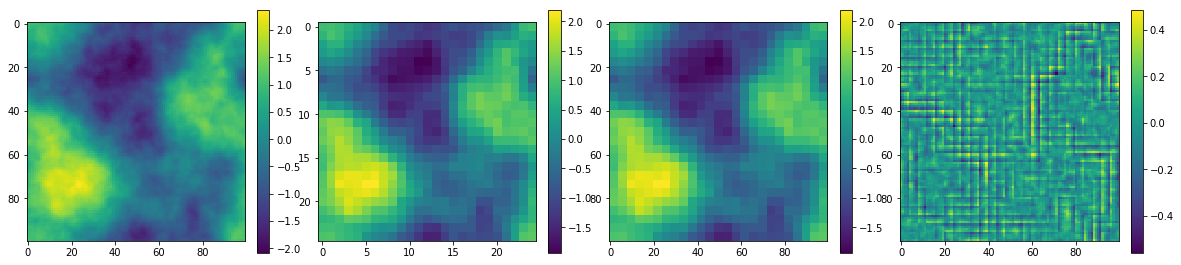

Norm original matrix: 100.0
Norm coarsened matrix: 24.7946634467
Norm uncoarsened matrix: 99.1786537868
Norm of their difference: 12.790411762
Percentage difference: 0.12790411762


In [48]:
matrix = gaussianRandomSpatialField()
coarsenedMatrix = coarsenMatrix(matrix, 4)
uncoarsenedMatrix = uncoarsenMatrix(coarsenedMatrix, 4)
matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 4, 1)
matplotlib.pyplot.imshow(matrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 2)
matplotlib.pyplot.imshow(coarsenedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 3)
matplotlib.pyplot.imshow(uncoarsenedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 4)
matplotlib.pyplot.imshow(uncoarsenedMatrix - matrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.show()
normMatrix = scipy.linalg.norm(matrix)
normDifference = scipy.linalg.norm(uncoarsenedMatrix - matrix)
print("Norm original matrix: " + str(normMatrix))
print("Norm coarsened matrix: " + str(scipy.linalg.norm(coarsenedMatrix)))
print("Norm uncoarsened matrix: " + str(scipy.linalg.norm(uncoarsenedMatrix)))
print("Norm of their difference: " + str(normDifference))
print("Percentage difference: " + str(normDifference / normMatrix))
_ = gc.collect()

The _testSingleSpatialFieldViaCoarsening_ function determines the percentage of the information lost in a coarsening process for matrices of various size and α's, and at various levels of coarsening. Often, one is mostly interested in the largest few singular values/vectors. These are the least affected by the coarsening process, as they describe large scale structure within the field. The function includes the parameter _p_ which reduces the input and output matrix to the largest _p_ singular values/vectors, to be able to see the information loss specifically on these modes.

In [49]:
def testSingleSpatialFieldViaCoarsening(size=200, alpha=-2, level=4, p=4):
    matrix = gaussianRandomSpatialField(alpha=alpha, size=size)
    coarsenedMatrix = coarsenMatrix(matrix, level)
    coarsenedMatrixReduced = reduceMatrix(coarsenedMatrix, p)
    uncoarsenedMatrix = uncoarsenMatrix(coarsenedMatrixReduced, level)
    matrixReduced = reduceMatrix(matrix, p)
    return scipy.linalg.norm(uncoarsenedMatrix - matrixReduced) / scipy.linalg.norm(matrixReduced)

At a coarsening level of 4, the coarsened matrix is 16 times smaller than the original. One could expect a large portion of the information to be lost, but this is not necessarily the case.

In [50]:
loop(testSingleSpatialFieldViaCoarsening)

2018-02-14 15:43:55,436 - INFO - Needed 5 iterations to converge.


0.068224136717415368

There is some effect of size on the information loss.

In [51]:
loop(testSingleSpatialFieldViaCoarsening, {"size": 100})

2018-02-14 15:43:55,484 - INFO - Needed 5 iterations to converge.


0.10561750144025224

In [52]:
loop(testSingleSpatialFieldViaCoarsening, {"size": 400})

2018-02-14 15:43:56,041 - INFO - Needed 5 iterations to converge.


0.030789468489299848

The effect of α is obviously important. Less negative α mean smaller scale structure, which can easily get lost during the coarsening.

In [53]:
loop(testSingleSpatialFieldViaCoarsening, {"alpha": -1})

2018-02-14 15:43:56,200 - INFO - Needed 5 iterations to converge.


0.24978945095963706

In [54]:
loop(testSingleSpatialFieldViaCoarsening, {"alpha": -4})

2018-02-14 15:43:56,339 - INFO - Needed 5 iterations to converge.


0.036864826725561559

Clearly, the level of coarsening is fundamental. It would be especially interesting to see the interplay between α and this level on the information loss.

In [55]:
loop(testSingleSpatialFieldViaCoarsening, {"level": 2})

2018-02-14 15:43:56,492 - INFO - Needed 5 iterations to converge.


0.025599939441052395

In [56]:
loop(testSingleSpatialFieldViaCoarsening, {"level": 10})

2018-02-14 15:43:56,626 - INFO - Needed 5 iterations to converge.


0.13669126176032145

Finally, as mentioned, one is usually only interested in the largest few singular modes. The largest modes at least affected by coarsening. When more modes are included in the comparison, the percentage of relevent information lost increases.

In [57]:
loop(testSingleSpatialFieldViaCoarsening, {"p": 2})

2018-02-14 15:43:56,783 - INFO - Needed 5 iterations to converge.


0.049712852032214948

In [58]:
loop(testSingleSpatialFieldViaCoarsening, {"p": 8})

2018-02-14 15:43:56,930 - INFO - Needed 5 iterations to converge.


0.064002672961631979

Let's plot the information loss as a function of the coarsening level for various α's.

In [59]:
def plotSingleSpatialFieldViaCoarsening(size=480, p=3):
    alphas = numpy.arange(-0.5, -2.1, -0.25)
    levels = numpy.concatenate((numpy.arange(2, 12.1, 2, dtype=int), numpy.arange(16, 24.1, 4, dtype=int)))
    for alpha in alphas:
        line = []
        for level in levels:
            value = loop(testSingleSpatialFieldViaCoarsening, {"size": size, "alpha": alpha, "level": level, "p": p})
            line.append(value)
        matplotlib.pyplot.plot(levels, line)
    matplotlib.pyplot.legend(["α: " + str(alpha) for alpha in alphas])
    matplotlib.pyplot.ylim(0.0, 1.0)
    matplotlib.pyplot.xlabel("level")
    matplotlib.pyplot.ylabel("% error")
    matplotlib.pyplot.savefig("Results/plotSingleSpatialFieldViaCoarsening.pdf")
    matplotlib.pyplot.show()

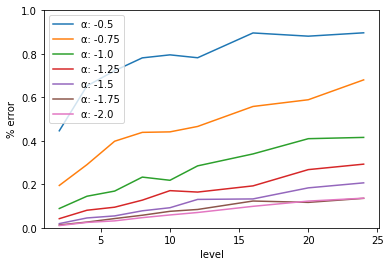

In [60]:
logger.disabled = True
plotSingleSpatialFieldViaCoarsening()
logger.disabled = False

Let's also plot the information loss as a function of the coarsening level for various _p_'s.

In [61]:
def plotSingleSpatialFieldViaCoarsening2(size=480, alpha=-2):
    ps = numpy.arange(1, 11.1, 2, dtype=int)
    levels = numpy.arange(4, 24.1, 4, dtype=int)
    for p in ps:
        line = []
        for level in levels:
            value = loop(testSingleSpatialFieldViaCoarsening, {"size": size, "alpha": alpha, "level": level, "p": p})
            line.append(value)
        matplotlib.pyplot.plot(levels, line)
    matplotlib.pyplot.legend(["p: " + str(p) for p in ps])
    matplotlib.pyplot.ylim(0.0, 0.18)
    matplotlib.pyplot.xlabel("level")
    matplotlib.pyplot.ylabel("% error")
    matplotlib.pyplot.savefig("Results/plotSingleSpatialFieldViaCoarsening2.pdf")
    matplotlib.pyplot.show()

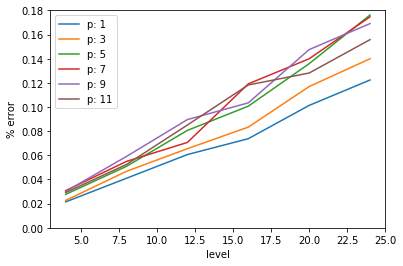

In [62]:
logger.disabled = True
plotSingleSpatialFieldViaCoarsening2()
logger.disabled = False

In [63]:
_ = gc.collect()

#### Product of Spatial-Temporal Fields via Spatial Coarsening

In the analysis of spatial-temporal fields, the spatial part of each time-slice can be coarsened. The _coarsenMatrix3D_ function simply loops over the temporal dimension and coarsens the spatial part.

In [64]:
def coarsenMatrix3D(array, level):
    h, w, d = array.shape
    coarsenedMatrix3D = numpy.empty((h // level, w // level, d))
    for i in range(d):
        coarsenedMatrix3D[:, :, i] = coarsenMatrix(array[:, :, i], level)
    return coarsenedMatrix3D

In a _CCA_ or _MCA_, the spatial-temporal fields are flattened, scaled and multiplied to obtain the cross-correlation matrix. To undo the effect of coarsening for such a product matrix, the steps are slightly more complicated. The _uncoarsenMatrixProduct_ function performs the two steps of uncoarsening.

In [65]:
def uncoarsenMatrixProduct(matrix, level, hh=None, ww=None):
    h, w = matrix.shape
    if hh is None or ww is None:
        hh = math.sqrt(h)
        ww = math.sqrt(w)
        if hh % 1 != 0 or ww % 1 != 0:
            print("Error")
            return []
        hh = int(hh)
        ww = int(ww)
    matrixGridded = matrixToGrid(matrix, hh, ww)
    matrixTiled = numpy.tile(matrixGridded, (1, level, level))
    matrixReconstructed = gridToMatrix(matrixTiled, level * h, level * w)
    matrixUncoarsened = uncoarsenMatrix(matrixReconstructed, level)
    return matrixUncoarsened

If one want to by-pass the cross-correlation function, the output of the coarsened SVD can also be uncoarsened directly. The _uncoarsenUSV_ function returns the _U_, _s_ and _V_ as if the coarsening had not occured.

In [66]:
def uncoarsenUSV(U, s, Vt, level, height):
    h, w = U.shape
    UGridded = matrixToGrid(U, height, w)
    UTiled = numpy.tile(UGridded, (level, 1))
    UReconstructed = gridToMatrix(UTiled, level * h, w)
    UGridded = matrixToGrid(UReconstructed, 1, w)
    UTiled = numpy.tile(UGridded, (level, 1))
    UReconstructed = gridToMatrix(UTiled, level * level * h, w)
    V = Vt.T
    h, w = V.shape
    VGridded = matrixToGrid(V, height, w)
    VTiled = numpy.tile(VGridded, (level, 1))
    VReconstructed = gridToMatrix(VTiled, level * h, w)
    VGridded = matrixToGrid(VReconstructed, 1, w)
    VTiled = numpy.tile(VGridded, (level, 1))
    VReconstructed = gridToMatrix(VTiled, level * level * h, w)
    return UReconstructed, s, VReconstructed.T

To see the effect of spatial-temporal coarsening, let's generate a _Gaussian Random Field_ and plot it together with a coarsened version. To be able to compare the two matrices, they need to be of the same size. Therefore, we also uncoarsen the coarsened matrix. The difference with the original field is shown in a plot. To determine precisely how much information is lost during the coarsening, we should look at the variance of the datasets. The norm of the difference between the uncoarsened matrix and the original is the amount of information lost in the coarsening process.

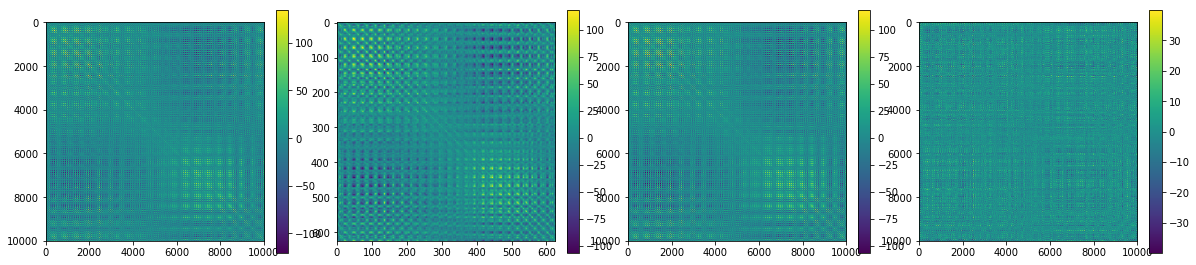

Norm original matrix: 199035.577665
Norm coarsened matrix: 12128.5230133
Norm uncoarsened matrix: 194056.368213
Norm of their difference: 44241.2379194
Percentage difference: 0.222278039124


In [67]:
spatialSize=100
temporalSize=40
alpha=-2
level=4
matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
matrixFlattened1, matrixFlattened2 = splitAndFlattenSpatialTemporalField(matrixCombined)
U1, s1, Vt1 = qrProductSVD(matrixFlattened1, matrixFlattened2)
reconstructedMatrix = usvToMatrix(U1, s1, Vt1)
matrixCombinedCoarsened = coarsenMatrix3D(matrixCombined, level)
matrixCoarsened1, matrixCoarsened2 = splitAndFlattenSpatialTemporalField(matrixCombinedCoarsened)
U2, s2, Vt2 = qrProductSVD(matrixCoarsened1, matrixCoarsened2)
reconstructedCoarsenedMatrix = usvToMatrix(U2, s2, Vt2)
reconstructedUncoarsenedMatrix = uncoarsenMatrixProduct(reconstructedCoarsenedMatrix, level)
matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 4, 1)
matplotlib.pyplot.imshow(reconstructedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 2)
matplotlib.pyplot.imshow(reconstructedCoarsenedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 3)
matplotlib.pyplot.imshow(reconstructedUncoarsenedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 4)
matplotlib.pyplot.imshow(reconstructedUncoarsenedMatrix - reconstructedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.show()
normMatrix = scipy.linalg.norm(reconstructedMatrix)
normDifference = scipy.linalg.norm(reconstructedMatrix - reconstructedUncoarsenedMatrix)
print("Norm original matrix: " + str(normMatrix))
print("Norm coarsened matrix: " + str(scipy.linalg.norm(reconstructedCoarsenedMatrix)))
print("Norm uncoarsened matrix: " + str(scipy.linalg.norm(reconstructedUncoarsenedMatrix)))
print("Norm of their difference: " + str(normDifference))
print("Percentage difference: " + str(normDifference / normMatrix))
_ = gc.collect()

The _testProductSpatialTemporalFieldsViaCoarsening_ function determines the percentage of the information lost in a coarsening process for matrices of various sizes and α's, and at various levels of coarsening. The two input matrices used here are similar, as they are generated by the same _Gaussian Random Process_. Therefore, they will correlate highly and the bases in which they are best described will be similar. In principle, any two datasets can be analysed and the amount of information lost during the coarsening process will likely depend on the similarity between the two datasets. This is one aspect which we do not cover here and leave for further research.

In [68]:
def testProductSpatialTemporalFieldsViaCoarsening(spatialSize=100, temporalSize=60, alpha=-2, level=4, modes=8):
    matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
    matrixFlattened1, matrixFlattened2 = splitAndFlattenSpatialTemporalField(matrixCombined)
    U1, s1, Vt1 = qrProductSVD(matrixFlattened1, matrixFlattened2)
    U1, s1, Vt1 = reduceUSV(U1, s1, Vt1, modes)
    matrixCombinedCoarsened = coarsenMatrix3D(matrixCombined, level)
    matrixCoarsened1, matrixCoarsened2 = splitAndFlattenSpatialTemporalField(matrixCombinedCoarsened)
    U2, s2, Vt2 = qrProductSVD(matrixCoarsened1, matrixCoarsened2)
    U2, s2, Vt2 = reduceUSV(U2, s2, Vt2, modes)
    U2, s2, Vt2 = uncoarsenUSV(U2, s2, Vt2, level, spatialSize // level)
    return percentageNormDifferenceFromUSVs(U1, s1, Vt1, U2, s2, Vt2)

Due to the multiplication step in this analysis, the typical error due to coarsening is larger than before.

In [69]:
loop(testProductSpatialTemporalFieldsViaCoarsening)

2018-02-14 15:45:41,126 - INFO - Needed 5 iterations to converge.


0.23938550254153917

One could vary both the spatial and the temporal size and examine the effect of the amount of information lost. For simplicity, we only vary the temporal size, which seems to not have a large effect.

In [70]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"temporalSize": 20})

2018-02-14 15:45:42,155 - INFO - Needed 5 iterations to converge.


0.21794455941809213

In [71]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"temporalSize": 100})

2018-02-14 15:45:47,510 - INFO - Needed 5 iterations to converge.


0.180830484199105

As before, α plays an important part, with more negative α's leading to a less dramatic loss in information due to coarsening.

In [72]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"alpha": -1})

2018-02-14 15:45:50,485 - INFO - Needed 5 iterations to converge.


0.86052964855543457

In [73]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"alpha": -4})

2018-02-14 15:45:53,416 - INFO - Needed 5 iterations to converge.


0.098926993461403129

The result of varying the level of coarsening is shown below.

In [74]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"level": 2})

2018-02-14 15:45:56,449 - INFO - Needed 5 iterations to converge.


0.10007818305257114

In [75]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"level": 10})

2018-02-14 15:45:59,323 - INFO - Needed 5 iterations to converge.


0.42765528248498719

Finally, we can again examine the effect of taking into account more or less modes.

In [76]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"modes": 4})

2018-02-14 15:46:02,292 - INFO - Needed 5 iterations to converge.


0.16494356988111689

In [77]:
loop(testProductSpatialTemporalFieldsViaCoarsening, {"modes": 16})

2018-02-14 15:46:05,353 - INFO - Needed 5 iterations to converge.


0.20563508559799457

Let's plot the information loss as a function of the coarsening level for various α's. The spatial size is set to a common mutiple of the levels, so that coarsening is straightforward.

In [78]:
def plotProductSpatialTemporalFieldsViaCoarsening(modes=8):
    alphas = numpy.arange(-0.5, -2.1, -0.25)
    levels = [2, 4, 8, 12, 16, 24]
    for alpha in alphas:
        line = []
        for level in levels:
            value = loop(testProductSpatialTemporalFieldsViaCoarsening, {"spatialSize": 96, "alpha": alpha, "level": level, "modes": modes})
            line.append(value)
        matplotlib.pyplot.plot(levels, line)
    matplotlib.pyplot.legend(["α: " + str(alpha) for alpha in alphas])
    matplotlib.pyplot.ylim(0.0, 1.05)
    matplotlib.pyplot.xlabel("level")
    matplotlib.pyplot.ylabel("% error")
    matplotlib.pyplot.savefig("Results/plotProductSpatialTemporalFieldsViaCoarsening.pdf")
    matplotlib.pyplot.show()

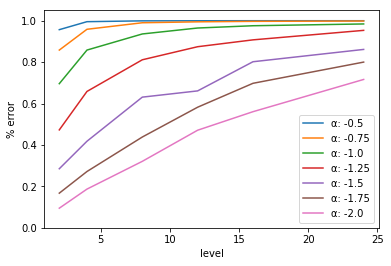

In [79]:
logger.disabled = True
plotProductSpatialTemporalFieldsViaCoarsening()
logger.disabled = False

In [80]:
_ = gc.collect()

### Efficient Approximate SVD via Dimensionality Reduction

The spatial coarsening process is intuitive and easy to implement. It is not, however, the most efficient way to reduce the size of a dataset. Dimensionality reduction refers to discarding modes which contribute little to the variance in a dataset. An SVD is precisely the procedure used to find modes which explain as much variance as possible. Discarding the smallest singular values/vectors is, therefore, the most efficient form of dimensionality reduction. Performing an SVD on a large dataset, however, is computationally costly. The Randomised Dimensionality Reduction process is far more efficient.

#### Single Spatial Field via Randomised Dimensionality Reduction

The _reduceSizeRandomisedSquare_ function reduces the input matrix to a smaller square matrix of _l_ by _l_. It also gives two projection matrices which can bring the rows and columns of this smaller matrix back to the bases of the original input. To make the result more precise, the procedure can be repeated multiple times. The parameter _i_ indicates how many loops are performed.

In [81]:
def reduceSizeRandomisedSquare(A, i, l):
    # Based on: reference to Mark Tygert
    h, w = A.shape
    AW = A @ numpy.random.normal(0, 1, (w, l))
    H, RH = scipy.linalg.qr(AW, mode = "economic")
    ATH = A.T @ H
    W, RW = scipy.linalg.qr(ATH, mode = "economic")
    for _ in range(i):
        AW = A @ W
        H, RH = scipy.linalg.qr(AW, mode = "economic")
        ATH = A.T @ H
        W, RW = scipy.linalg.qr(ATH, mode = "economic")
    L = H.T @ A @ W
    return H, L, W

The _reconstructSquareRandomisedSizeReducedMatrix_ function can take the output of the previous function and reconstruct as much as possible from the original matrix.

In [82]:
def reconstructSquareRandomisedSizeReducedMatrix(H, L, W):
    return H @ L @ W.T

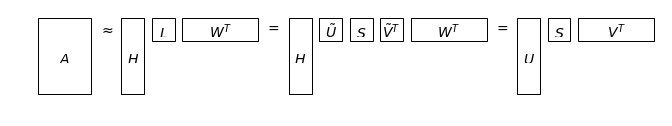

In [83]:
matrixDescription = [
    {"type":"Matrix", "width":0.7, "height":1, "text":r"$A_{}^{}$"},
    {"type":"Symbol", "symbol":r"$\approx$"},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$H_{}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$L_{}^{}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$W_{}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$H_{}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$\tilde{U}_{}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$S_{}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$\tilde{V}_{}^{T}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$W_{}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$U_{}^{}}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$S_{}^{}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$V_{}^{T}$"},
]
plotMatrixMultiplication(matrixDescription, "Results/reduceSizeRandomisedSquare.pdf")

To see the effect of dimensionality reduction, let's generate a _Gaussian Random Field_ and plot it together with a reduced version. To determine precisely how much information is lost during the reduction, we should look at the variance of the datasets. The norm of the difference between the reduced matrix and the original is the amount of information lost in the reduction process.

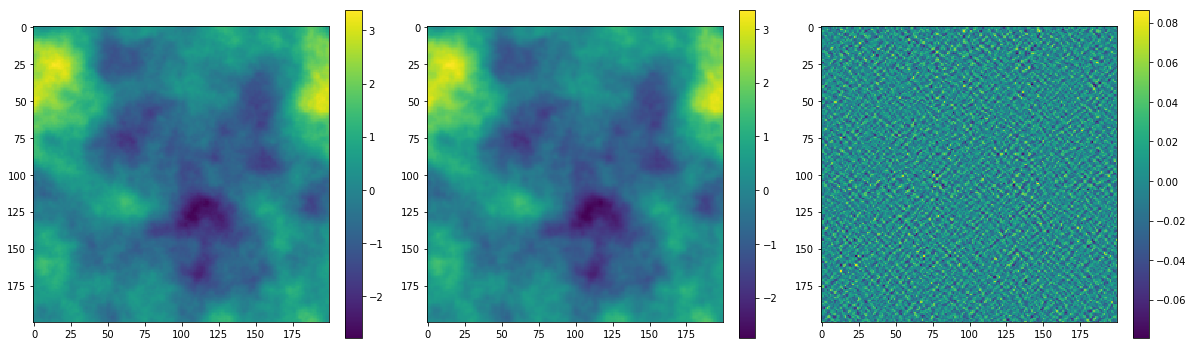

Norm original matrix: 200.0
Norm reduced matrix: 199.958591957
Norm of their difference: 4.06958261812
Percentage difference: 0.0203479130906


In [84]:
size = 200
alpha = -2
level = 4
i = 1
matrix = gaussianRandomSpatialField(alpha, size)
H, L, W = reduceSizeRandomisedSquare(matrix, i, size // level)
reconstructedmatrix = reconstructSquareRandomisedSizeReducedMatrix(H, L, W)
matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 3, 1)
matplotlib.pyplot.imshow(matrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 3, 2)
matplotlib.pyplot.imshow(reconstructedmatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 3, 3)
matplotlib.pyplot.imshow(reconstructedmatrix - matrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.show()
normMatrix = scipy.linalg.norm(matrix)
normDifference = scipy.linalg.norm(reconstructedmatrix - matrix)
print("Norm original matrix: " + str(normMatrix))
print("Norm reduced matrix: " + str(scipy.linalg.norm(reconstructedmatrix)))
print("Norm of their difference: " + str(normDifference))
print("Percentage difference: " + str(normDifference / normMatrix))
_ = gc.collect()

The _testRandomisedSizeReducedMatrix_ function determines the percentage of the information lost in a reduction process for matrices of various sizes and α's, and at various levels of reduction.

In [85]:
def testRandomisedSizeReducedMatrix(size=200, alpha=-2, level=4, i=1, modes=4):
    matrix = gaussianRandomSpatialField(alpha, size)
    matrixReduced = reduceMatrix(matrix, modes)
    H, L, W = reduceSizeRandomisedSquare(matrix, i, size // level)
    LReduced = reduceMatrix(L, modes)
    reconstructedmatrix = reconstructSquareRandomisedSizeReducedMatrix(H, LReduced, W)
    return scipy.linalg.norm(reconstructedmatrix - matrixReduced) / scipy.linalg.norm(matrixReduced)

As seen, it is possible for some fields to be represented by matrices of much smaller sizes without losing any substantial amount of information. This is obvious when one realises the singular modes which are removed during the reduction are the smallest ones, described by the tail-end of the power law.

In [86]:
loop(testRandomisedSizeReducedMatrix)

2018-02-14 15:48:03,285 - INFO - Needed 5 iterations to converge.


8.6150841058948288e-07

If there is an effect of size, it is small.

In [87]:
loop(testRandomisedSizeReducedMatrix, {"size": 100})

2018-02-14 15:48:03,342 - INFO - Needed 5 iterations to converge.


3.2441368046102265e-05

In [88]:
loop(testRandomisedSizeReducedMatrix, {"size": 400})

2018-02-14 15:48:04,007 - INFO - Needed 5 iterations to converge.


3.9743387471311322e-08

The tail-end of a power law with a less negative exponent is larger, so the information lost during the reduction of such a field is larger too.

In [89]:
loop(testRandomisedSizeReducedMatrix, {"alpha": -1})

2018-02-14 15:48:04,171 - INFO - Needed 5 iterations to converge.


0.0055476263213250655

In [90]:
loop(testRandomisedSizeReducedMatrix, {"alpha": -4})

2018-02-14 15:48:04,329 - INFO - Needed 5 iterations to converge.


1.3774355877742762e-14

Clearly, the level of reduction is important.

In [91]:
loop(testRandomisedSizeReducedMatrix, {"level": 2})

2018-02-14 15:48:04,552 - INFO - Needed 5 iterations to converge.


2.7186425078100404e-08

In [92]:
loop(testRandomisedSizeReducedMatrix, {"level": 8})

2018-02-14 15:48:04,685 - INFO - Needed 5 iterations to converge.


3.8494157449044418e-05

As mentioned, the randomised reduction algorithm includes a loop which makes the projections to lower dimensions more precise. The effect, especially from 0 to 1, seems to be large.

In [93]:
loop(testRandomisedSizeReducedMatrix, {"i": 0})

2018-02-14 15:48:04,844 - INFO - Needed 5 iterations to converge.


0.0065545970688668537

In [94]:
loop(testRandomisedSizeReducedMatrix, {"i": 2})

2018-02-14 15:48:05,002 - INFO - Needed 5 iterations to converge.


5.9470867022717738e-10

In the review article by Halko, Martinsson and Tropp on randomised dimensionality reduction, it is suggested to oversample the reduction. This is because the error introduced in the process is of the same order as the size of the last sampled singular value. If one is interested in the _k_ dominant modes, reducing to a _k + l_, for some small _l_, rank approximation will ensure the first _k_ modes are approximated quite well. Indeed, as seen below, the more modes one is interested in, the larger the difference compared with the original matrix.

In [95]:
loop(testRandomisedSizeReducedMatrix, {"modes": 2})

2018-02-14 15:48:05,154 - INFO - Needed 5 iterations to converge.


1.2930050189346067e-07

In [96]:
loop(testRandomisedSizeReducedMatrix, {"modes": 8})

2018-02-14 15:48:05,300 - INFO - Needed 5 iterations to converge.


1.1554336881804619e-05

In [97]:
_ = gc.collect()

#### Product of Spatial-Temporal Fields via Randomised Dimensionality Reduction

The Randomised Dimensionality Reduction process can also be applied to the _CCA_ or _MCA_ analysis of two spatial-temporal fields. Similar to the QR Product SVD, it has the advantage that the SVD is applied to a small _l x l_ matrix. The result will be an approximation, but, as we will see, can be close to the real solution.

In [98]:
def randomisedSquareProductSVD(A1, A2, i, l):
    H1, L1, W1 = reduceSizeRandomisedSquare(A1, i, l)
    H2, L2, W2 = reduceSizeRandomisedSquare(A2, i, l)
    C = L1 @ W1.T @ W2 @ L2.T
    UC, s, VCt = scipy.linalg.svd(C, full_matrices = False)
    U = H1 @ UC
    Vt = VCt @ H2.T
    return U, s, Vt

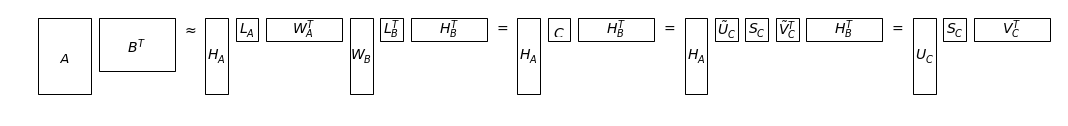

In [99]:
matrixDescription = [
    {"type":"Matrix", "width":0.7, "height":1, "text":r"$A_{}^{}$"},
    {"type":"Matrix", "width":1, "height":0.7, "text":r"$B_{}^{T}$"},
    {"type":"Symbol", "symbol":r"$\approx$"},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$H_{A}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$L_{A}^{}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$W_{A}^{T}$"},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$W_{B}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$L_{B}^{T}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$H_{B}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$H_{A}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$C_{}^{}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$H_{B}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$H_{A}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$\tilde{U}_{C}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$S_{C}^{}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$\tilde{V}_{C}^{T}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$H_{B}^{T}$"},
    {"type":"Symbol", "symbol":"="},
    {"type":"Matrix", "width":0.3, "height":1, "text":r"$U_{C}^{}}$"},
    {"type":"Matrix", "width":0.3, "height":0.3, "text":r"$S_{C}^{}$"},
    {"type":"Matrix", "width":1, "height":0.3, "text":r"$V_{C}^{T}$"},
]
plotMatrixMultiplication(matrixDescription, "Results/randomisedSquareProductSVD.pdf")

To see the effect of dimensionality reduction on such a matrix product, let's generate two _Gaussian Random Fields_ and plot their corss-correlation matrix together with a reduced version. To determine precisely how much information is lost during the reduction, we should look at the variance of the datasets. The norm of the difference between the reduced matrix and the original is the amount of information lost in the reduction process.

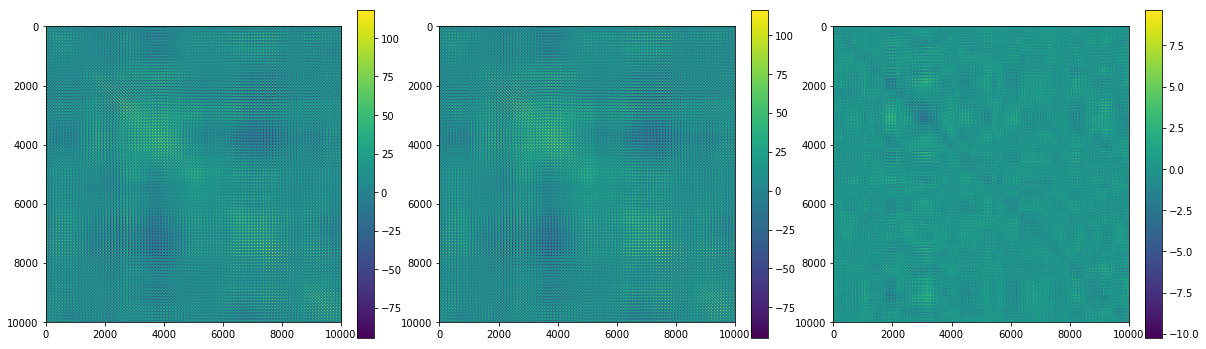

Norm original matrix: 203634.77032
Norm reconstructed matrix: 203441.397302
Norm of their difference: 8872.29097906
Percentage difference: 0.0435696269607


In [100]:
spatialSize=100
temporalSize=40
alpha=-2
level=4
i=1
matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
matrixFlattened1, matrixFlattened2 = splitAndFlattenSpatialTemporalField(matrixCombined)
U, s, Vt = qrProductSVD(matrixFlattened1, matrixFlattened2)
reducedMatrix = usvToMatrix(U, s, Vt)
U, s, Vt = randomisedSquareProductSVD(matrixFlattened1, matrixFlattened2, i, int(temporalSize / level))
reconstructedMatrix = usvToMatrix(U, s, Vt)
matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 3, 1)
matplotlib.pyplot.imshow(reducedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 3, 2)
matplotlib.pyplot.imshow(reconstructedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 3, 3)
matplotlib.pyplot.imshow(reconstructedMatrix - reducedMatrix)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.show()
normMatrix = scipy.linalg.norm(reducedMatrix)
normDifference = scipy.linalg.norm(reconstructedMatrix - reducedMatrix)
print("Norm original matrix: " + str(normMatrix))
print("Norm reconstructed matrix: " + str(scipy.linalg.norm(reconstructedMatrix)))
print("Norm of their difference: " + str(normDifference))
print("Percentage difference: " + str(normDifference / normMatrix))
_ = gc.collect()

The _testRandomisedSizeReducedMatrixProduct_ function determines the percentage of the information lost in a reduction process for matrices of various sizes and α's, and at various levels of reduction. The two input matrices used here are similar, as they are generated by the same _Gaussian Random Process_. Therefore, they will correlate highly and the bases in which they are best described will be similar. In principle, any two datasets can be analysed and the amount of information lost during the coarsening process will likely depend on the similarity between the two datasets. This is one aspect which we do not cover here and leave for further research.

In [101]:
def testRandomisedSizeReducedMatrixProduct(spatialSize=100, temporalSize=60, alpha=-2, level=4, i=1, modes=8):
    l = int(temporalSize / level)
    matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
    matrixFlattened1, matrixFlattened2 = splitAndFlattenSpatialTemporalField(matrixCombined)
    U, s, Vt = qrProductSVD(matrixFlattened1, matrixFlattened2)
    U, s, Vt = reduceUSV(U, s, Vt, min(modes, l))
    U2, s2, Vt2 = randomisedSquareProductSVD(matrixFlattened1, matrixFlattened2, i, l)
    U2, s2, Vt2 = reduceUSV(U2, s2, Vt2, min(modes, l))
    return percentageNormDifferenceFromUSVs(U, s, Vt, U2, s2, Vt2)

Due to the multiplication step in this analysis, the typical error due to reduction is larger than before.

In [102]:
loop(testRandomisedSizeReducedMatrixProduct)

2018-02-14 15:48:22,102 - INFO - Needed 5 iterations to converge.


0.014536682283010688

There is an affect of temporal size on the information loss. The _randomisedSquareProductSVD_ function is especially useful for square input matrices. To be able to do the comparisons with the full SVD quickly, we use rectangular matrices here. The larger the temporal size, the more square the input matrices.

In [103]:
loop(testRandomisedSizeReducedMatrixProduct, {"temporalSize": 20})

2018-02-14 15:48:23,048 - INFO - Needed 5 iterations to converge.


0.084059463416574734

In [104]:
loop(testRandomisedSizeReducedMatrixProduct, {"temporalSize": 100})

2018-02-14 15:48:28,609 - INFO - Needed 5 iterations to converge.


0.0025387132917925955

As before, the scale of the structure of the field influences the information loss. The effect in this case can be quite dramatic. Especially for more negative α, this procedure performs much better than the coarsening procedure.

In [105]:
loop(testRandomisedSizeReducedMatrixProduct, {"alpha": -1})

2018-02-14 15:48:31,664 - INFO - Needed 5 iterations to converge.


0.77195228713143216

In [106]:
loop(testRandomisedSizeReducedMatrixProduct, {"alpha": -4})

2018-02-14 15:48:34,680 - INFO - Needed 5 iterations to converge.


5.0195766100751981e-07

The level of reduction refers to the portion of the temporal size which is kept. Obviously, highly level reductions leads to worse results.

In [107]:
loop(testRandomisedSizeReducedMatrixProduct, {"level": 2})

2018-02-14 15:48:37,940 - INFO - Needed 5 iterations to converge.


0.0016935868042483259

In [108]:
loop(testRandomisedSizeReducedMatrixProduct, {"level": 8})

2018-02-14 15:48:40,960 - INFO - Needed 5 iterations to converge.


0.076939646203276715

Again, the number of iterations of the randomised dimensionality reduction procedure can influence the results.

In [109]:
loop(testRandomisedSizeReducedMatrixProduct, {"i": 0})

2018-02-14 15:48:43,947 - INFO - Needed 5 iterations to converge.


0.21308569804238342

In [110]:
loop(testRandomisedSizeReducedMatrixProduct, {"i": 2})

2018-02-14 15:48:47,109 - INFO - Needed 5 iterations to converge.


0.0027473683400065473

The number of modes of interest also affect the resulting information loss.

In [111]:
loop(testRandomisedSizeReducedMatrixProduct, {"modes": 4})

2018-02-14 15:48:50,199 - INFO - Needed 5 iterations to converge.


0.0042120745706013245

In [112]:
loop(testRandomisedSizeReducedMatrixProduct, {"modes": 16})

2018-02-14 15:48:53,381 - INFO - Needed 5 iterations to converge.


0.020941694438478282

Let's plot the information loss as a function of the reduction level for various α's.

In [113]:
def plotRandomisedSizeReducedMatrixProduct(modes=8):
    alphas = numpy.arange(-0.5, -2.1, -0.25)
    levels = numpy.arange(2, 8.1, 1)
    for alpha in alphas:
        line = []
        for level in levels:
            value = loop(testRandomisedSizeReducedMatrixProduct, {"alpha": alpha, "level": level, "modes": modes})
            line.append(value)
        matplotlib.pyplot.plot(levels, line)
    matplotlib.pyplot.legend(["α: " + str(alpha) for alpha in alphas])
    matplotlib.pyplot.ylim(0.0, 1.2)
    matplotlib.pyplot.xlabel("level")
    matplotlib.pyplot.ylabel("% error")
    matplotlib.pyplot.savefig("Results/plotRandomisedSizeReducedMatrixProduct.pdf")
    matplotlib.pyplot.show()

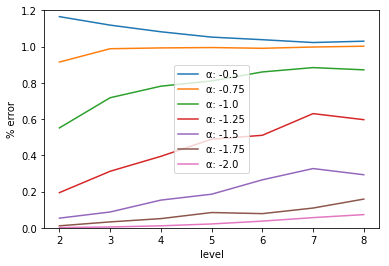

In [114]:
logger.disabled = True
plotRandomisedSizeReducedMatrixProduct()
logger.disabled = False

In [115]:
_ = gc.collect()

### Noise Reduction via Pre-Filtering

Text

#### Single Spatial Field

Text

In [ ]:
def addNoise(matrix, noiseLevel=1.0):
    return matrix + numpy.random.normal(loc=0.0, scale=noiseLevel, size=matrix.shape)

Text

In [ ]:
def testNoiseReduction(size=200, alpha=-2, noiseScale=0.1, reduction=3):
    matrix = gaussianRandomSpatialField(alpha, size)
    noiseLevel = noiseScale * numpy.std(matrix)
    matrixNoise = addNoise(matrix, noiseLevel)
    matrixNoiseReduced = reduceMatrix(matrixNoise, size//reduction)
    normMatrix = scipy.linalg.norm(matrix)
    normDifferenceMatrixNoise = scipy.linalg.norm(matrix - matrixNoise)
    normDifferenceMatrixNoiseReduced = scipy.linalg.norm(matrix - matrixNoiseReduced)
    percentageNormDifference1 = normDifferenceMatrixNoise / normMatrix
    percentageNormDifference2 = normDifferenceMatrixNoiseReduced / normMatrix
    percentageNormDifference3 = normDifferenceMatrixNoiseReduced / normDifferenceMatrixNoise
    return percentageNormDifference1, percentageNormDifference2, percentageNormDifference3

Text

In [ ]:
loop(testNoiseReduction)

In [ ]:
loop(testNoiseReduction, {"size": 100})

In [ ]:
loop(testNoiseReduction, {"size": 400})

In [ ]:
loop(testNoiseReduction, {"alpha": -1})

In [ ]:
loop(testNoiseReduction, {"alpha": -4})

In [ ]:
loop(testNoiseReduction, {"noiseScale": 0.05})

In [ ]:
loop(testNoiseReduction, {"noiseScale": 0.5})

In [ ]:
loop(testNoiseReduction, {"reduction": 2})

In [ ]:
loop(testNoiseReduction, {"reduction": 4})

#### Product of Spatial Fields

Text

In [ ]:
def testNoiseReductionProduct(size=200, alpha=-2, noiseScale=0.1, reduction=3, reconstruction=4):
    matrixCombined = gaussianRandomSpatialTemporalField(alpha, size, 2)
    noiseLevel = noiseScale * numpy.std(matrixCombined)
    matrix1 = matrixCombined[:, :, 0]
    matrix2 = matrixCombined[:, :, 1]
    productMatrix = matrix1 @ matrix2.T
    productMatrixReconstructed = reduceMatrix(productMatrix, size//reconstruction)
    matrixNoise1 = addNoise(matrix1, noiseLevel)
    matrixNoise2 = addNoise(matrix2, noiseLevel)
    productMatrixNoise = matrixNoise1 @ matrixNoise2.T
    productMatrixNoiseReconstructed = reduceMatrix(productMatrixNoise, size//reconstruction)
    matrixNoiseReduced1 = reduceMatrix(matrixNoise1, size//reduction)
    matrixNoiseReduced2 = reduceMatrix(matrixNoise2, size//reduction)
    productMatrixNoiseReduced = matrixNoiseReduced1 @ matrixNoiseReduced2.T    
    productMatrixNoiseReducedReconstructed = reduceMatrix(productMatrixNoiseReduced, size//reconstruction)
    normProductMatrix = scipy.linalg.norm(productMatrixReconstructed)
    normDifferenceProductMatrixNoise = scipy.linalg.norm(productMatrixReconstructed - productMatrixNoiseReconstructed)
    normDifferenceProductMatrixNoiseReduced = scipy.linalg.norm(productMatrixReconstructed - productMatrixNoiseReducedReconstructed)
    percentageNormDifference1 = normDifferenceProductMatrixNoise / normProductMatrix
    percentageNormDifference2 = normDifferenceProductMatrixNoiseReduced / normProductMatrix
    percentageNormDifference3 = normDifferenceProductMatrixNoiseReduced / normDifferenceProductMatrixNoise
    return percentageNormDifference1, percentageNormDifference2, percentageNormDifference3

Text

In [ ]:
loop(testNoiseReductionProduct)

In [ ]:
loop(testNoiseReductionProduct, {"size": 100})

In [ ]:
loop(testNoiseReductionProduct, {"size": 400})

In [ ]:
loop(testNoiseReductionProduct, {"alpha": -1})

In [ ]:
loop(testNoiseReductionProduct, {"alpha": -4})

In [ ]:
loop(testNoiseReductionProduct, {"noiseScale": 0.05})

In [ ]:
loop(testNoiseReductionProduct, {"noiseScale": 0.5})

In [ ]:
loop(testNoiseReductionProduct, {"reduction": 2})

In [ ]:
loop(testNoiseReductionProduct, {"reduction": 4})

In [ ]:
loop(testNoiseReductionProduct, {"reconstruction": 3})

In [ ]:
loop(testNoiseReductionProduct, {"reconstruction": 5})

#### Product of Spatial Fields with Correlated Noise

Text

In [ ]:
def addCorrelatedNoise3D(matrix, noiseLevel=1.0):
    noise = noiseLevel * gaussianRandomSpatialTemporalField(alpha/4, matrix.shape[0], matrix.shape[2])  
    return matrix + noise

Text

In [ ]:
def testNoiseReductionCorrelatedNoiseProduct(size=200, alpha=-2, noiseScale=0.1, reduction=3, reconstruction=4):
    matrixCombined = gaussianRandomSpatialTemporalField(alpha, size, 2)
    noiseLevel = noiseScale * numpy.std(matrixCombined)
    matrixCombinedNoise = addCorrelatedNoise3D(matrixCombined, noiseLevel)
    matrix1, matrix2 = splitSpatialTemporalField(matrixCombined)
    matrixNoise1, matrixNoise2 = splitSpatialTemporalField(matrixCombinedNoise)
    productMatrix = matrix1[:, :, 0] @ matrix2[:, :, 0].T
    productMatrixReconstructed = reduceMatrix(productMatrix, size//reconstruction)
    productMatrixNoise = matrixNoise1[:, :, 0] @ matrixNoise2[:, :, 0].T
    productMatrixNoiseReconstructed = reduceMatrix(productMatrixNoise, size//reconstruction)
    matrixNoiseReduced1 = reduceMatrix(matrixNoise1[:, :, 0], size//reduction)
    matrixNoiseReduced2 = reduceMatrix(matrixNoise2[:, :, 0], size//reduction)
    productMatrixNoiseReduced = matrixNoiseReduced1 @ matrixNoiseReduced2.T    
    productMatrixNoiseReducedReconstructed = reduceMatrix(productMatrixNoiseReduced, size//reconstruction)
    normProductMatrix = scipy.linalg.norm(productMatrixReconstructed)
    normDifferenceProductMatrixNoise = scipy.linalg.norm(productMatrixReconstructed - productMatrixNoiseReconstructed)
    normDifferenceProductMatrixNoiseReduced = scipy.linalg.norm(productMatrixReconstructed - productMatrixNoiseReducedReconstructed)
    percentageNormDifference1 = normDifferenceProductMatrixNoise / normProductMatrix
    percentageNormDifference2 = normDifferenceProductMatrixNoiseReduced / normProductMatrix
    percentageNormDifference3 = normDifferenceProductMatrixNoiseReduced / normDifferenceProductMatrixNoise
    return percentageNormDifference1, percentageNormDifference2, percentageNormDifference3

Text

In [ ]:
loop(testNoiseReductionCorrelatedNoiseProduct)

In [ ]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"size": 100})

In [ ]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"size": 400})

In [ ]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"alpha": -1})

In [ ]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"alpha": -4})

In [ ]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"noiseScale": 0.05})

In [ ]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"noiseScale": 0.5})

In [ ]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"reduction": 2})

In [ ]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"reduction": 4})

In [ ]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"reconstruction": 3})

In [ ]:
loop(testNoiseReductionCorrelatedNoiseProduct, {"reconstruction": 5})

#### Product of Spatial-Temporal Fields with Correlated Noise

Text

In [ ]:
def testNoiseReductionSpatialTemporalField(spatialSize=100, temporalSize=40, alpha=-2, noiseScale=0.1, reduction=3, reconstruction=4):
    matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
    noiseLevel = noiseScale * numpy.std(matrixCombined)
    matrixCombinedNoise = addCorrelatedNoise3D(matrixCombined, noiseLevel)
    matrixFlattened1, matrixFlattened2 = splitAndFlattenSpatialTemporalField(matrixCombined)
    matrixNoise1, matrixNoise2 = splitAndFlattenSpatialTemporalField(matrixCombinedNoise)
    matrixNoiseReduced1 = reduceMatrix(matrixNoise1, temporalSize//reduction)
    matrixNoiseReduced2 = reduceMatrix(matrixNoise2, temporalSize//reduction)
    U, s, Vt = qrProductSVD(matrixFlattened1, matrixFlattened2)
    UNoise, sNoise, VtNoise = qrProductSVD(matrixNoise1, matrixNoise2)
    UNoiseReduced, sNoiseReduced, VtNoiseReduced = qrProductSVD(matrixNoiseReduced1, matrixNoiseReduced2)
    reconstructedMatrix = usvToReducedMatrix(U, s, Vt, temporalSize//reconstruction)
    reconstructedMatrixNoise = usvToReducedMatrix(UNoise, sNoise, VtNoise, temporalSize//reconstruction)
    reconstructedMatrixNoiseReduced = usvToReducedMatrix(UNoiseReduced, sNoiseReduced, VtNoiseReduced, temporalSize//reconstruction)
    normMatrix = scipy.linalg.norm(reconstructedMatrix)
    normDifferenceMatrixNoise = scipy.linalg.norm(reconstructedMatrix - reconstructedMatrixNoise)
    normDifferenceMatrixNoiseReduced = scipy.linalg.norm(reconstructedMatrix - reconstructedMatrixNoiseReduced)
    percentageNormDifference1 = normDifferenceMatrixNoise / normMatrix
    percentageNormDifference2 = normDifferenceMatrixNoiseReduced / normMatrix
    percentageNormDifference3 = normDifferenceMatrixNoiseReduced / normDifferenceMatrixNoise
    return percentageNormDifference1, percentageNormDifference2, percentageNormDifference3

Text

In [ ]:
loop(testNoiseReductionSpatialTemporalField)

In [ ]:
loop(testNoiseReductionSpatialTemporalField, {"temporalSize": 20})

In [ ]:
loop(testNoiseReductionSpatialTemporalField, {"temporalSize": 100})

In [ ]:
loop(testNoiseReductionSpatialTemporalField, {"alpha": -1})

In [ ]:
loop(testNoiseReductionSpatialTemporalField, {"alpha": -4})

In [ ]:
loop(testNoiseReductionSpatialTemporalField, {"noiseScale": 0.05})

In [ ]:
loop(testNoiseReductionSpatialTemporalField, {"noiseScale": 0.5})

In [ ]:
loop(testNoiseReductionSpatialTemporalField, {"reduction": 2})

In [ ]:
loop(testNoiseReductionSpatialTemporalField, {"reduction": 4})

In [ ]:
loop(testNoiseReductionSpatialTemporalField, {"reconstruction": 3})

In [ ]:
loop(testNoiseReductionSpatialTemporalField, {"reconstruction": 5})

#### Product of Standardised Spatial-Temporal Fields with Correlated Noise

Text

In [ ]:
def testNoiseReductionSpatialTemporalFieldCorrelation(spatialSize=100, temporalSize=40, alpha=-2, noiseScale=0.1, reduction=3, reconstruction=5):
    matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
    noiseLevel = noiseScale * numpy.std(matrixCombined)
    matrixCombinedNoise = addCorrelatedNoise3D(matrixCombined, noiseLevel)
    matrixFlattened1, matrixFlattened2 = splitAndFlattenSpatialTemporalField(matrixCombined)
    matrixScaled1 = centerAndStandardiseField(matrixFlattened1)
    matrixScaled2 = centerAndStandardiseField(matrixFlattened2)
    matrixNoise1, matrixNoise2 = splitAndFlattenSpatialTemporalField(matrixCombinedNoise)
    matrixNoiseScaled1 = centerAndStandardiseField(matrixNoise1)
    matrixNoiseScaled2 = centerAndStandardiseField(matrixNoise2)
    matrixNoiseReduced1 = reduceMatrix(matrixNoise1, temporalSize//reduction)
    matrixNoiseReduced2 = reduceMatrix(matrixNoise2, temporalSize//reduction)
    matrixNoiseReducedScaled1 = centerAndStandardiseField(matrixNoiseReduced1)
    matrixNoiseReducedScaled2 = centerAndStandardiseField(matrixNoiseReduced2)
    U, s, Vt = qrProductSVD(matrixScaled1, matrixScaled2)
    UNoise, sNoise, VtNoise = qrProductSVD(matrixNoiseScaled1, matrixNoiseScaled2)
    UNoiseReduced, sNoiseReduced, VtNoiseReduced = qrProductSVD(matrixNoiseReducedScaled1, matrixNoiseReducedScaled2)
    reconstructedMatrix = usvToReducedMatrix(U, s, Vt, temporalSize//reconstruction)
    reconstructedMatrixNoise = usvToReducedMatrix(UNoise, sNoise, VtNoise, temporalSize//reconstruction)
    reconstructedMatrixNoiseReduced = usvToReducedMatrix(UNoiseReduced, sNoiseReduced, VtNoiseReduced, temporalSize//reconstruction)
    normMatrix = scipy.linalg.norm(reconstructedMatrix)
    normDifferenceMatrixNoise = scipy.linalg.norm(reconstructedMatrix - reconstructedMatrixNoise)
    normDifferenceMatrixNoiseReduced = scipy.linalg.norm(reconstructedMatrix - reconstructedMatrixNoiseReduced)
    percentageNormDifference1 = normDifferenceMatrixNoise / normMatrix
    percentageNormDifference2 = normDifferenceMatrixNoiseReduced / normMatrix
    percentageNormDifference3 = normDifferenceMatrixNoiseReduced / normDifferenceMatrixNoise
    return percentageNormDifference1, percentageNormDifference2, percentageNormDifference3

Text

In [ ]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation)

In [ ]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"temporalSize": 20})

In [ ]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"temporalSize": 100})

In [ ]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"alpha": -1})

In [ ]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"alpha": -4})

In [ ]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"noiseScale": 0.05})

In [ ]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"noiseScale": 0.5})

In [ ]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"reduction": 2})

In [ ]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"reduction": 4})

In [ ]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"reconstruction": 3})

In [ ]:
loop(testNoiseReductionSpatialTemporalFieldCorrelation, {"reconstruction": 5})

## Real-World Applications

The following section will apply the same techniques to real datasets.

### Dataset Preperation

Text

In [116]:
def structureMatrix(dataVector, maskFlattened, maskShape):
    structuredMatrix = numpy.full(maskShape[0] * maskShape[1], numpy.nan, dtype=numpy.float64)
    structuredMatrix[maskFlattened] = dataVector
    structuredMatrix = structuredMatrix.reshape(maskShape)
    return structuredMatrix

In [117]:
def structureMatrix3D(dataVectors, maskFlattened, maskShape):
    _, d = dataVectors.shape
    h, w = maskShape
    result = numpy.empty((h, w, d))
    for dd in range(d):
        result[:, :, dd] = structureMatrix(dataVectors[:, dd], maskFlattened, maskShape)
    return result

In [118]:
def plotMatrix(dataVector, maskFlattened, maskShape, filePath = None):
    structuredMatrix = structureMatrix(dataVector, maskFlattened, maskShape)
    matplotlib.pyplot.imshow(structuredMatrix, aspect="auto")
    matplotlib.pyplot.colorbar()
    if filePath is not None:
        matplotlib.pyplot.savefig(filePath)
    matplotlib.pyplot.show()

In [119]:
_ = gc.collect()

In [120]:
logger.info("Running numpy.load()")
maskFlattened = numpy.load("Data/Mask.npz")["maskFlattened"]
maskShape = numpy.load("Data/Mask.npz")["maskShape"]
logger.info("Ending numpy.load()")

2018-02-14 15:51:31,633 - INFO - Running numpy.load()
2018-02-14 15:51:31,729 - INFO - Ending numpy.load()


In [121]:
logger.info("Running numpy.load()")
dataSetBloom = numpy.load("Data/Bloom.npz")["dataSetBloom"]
logger.info("Ending numpy.load()")

2018-02-14 15:51:31,736 - INFO - Running numpy.load()
2018-02-14 15:51:44,746 - INFO - Ending numpy.load()


In [122]:
logger.info("Running numpy.load()")
dataSetSos = numpy.load("Data/Sos.npz")["dataSetSos"]
logger.info("Ending numpy.load()")

2018-02-14 15:51:44,773 - INFO - Running numpy.load()
2018-02-14 15:52:00,820 - INFO - Ending numpy.load()


In [123]:
logger.info("Running Filter()")
dataSetBloomFiltered = dataSetBloom[maskFlattened]
logger.info("Ending Filter()")

2018-02-14 15:52:00,855 - INFO - Running Filter()
2018-02-14 15:52:12,493 - INFO - Ending Filter()


In [124]:
logger.info("Running Filter()")
dataSetSosFiltered = dataSetSos[maskFlattened]
logger.info("Ending Filter()")

2018-02-14 15:52:12,533 - INFO - Running Filter()
2018-02-14 15:52:19,946 - INFO - Ending Filter()


In [125]:
logger.info("Running Imputation()")
meanBloom = numpy.nanmean(dataSetBloomFiltered)
stdBloom = numpy.nanstd(dataSetBloomFiltered)
nansBloom = numpy.isnan(dataSetBloomFiltered)
numberOfNaNsBloom = numpy.count_nonzero(nansBloom)
imputedValuesBloom = numpy.random.normal(meanBloom, stdBloom, numberOfNaNsBloom)
dataSetBloomImputed = copy.copy(dataSetBloomFiltered)
dataSetBloomImputed[nansBloom] = imputedValuesBloom
logger.info("Ending Imputation()")

2018-02-14 15:52:20,008 - INFO - Running Imputation()
2018-02-14 15:52:30,785 - INFO - Ending Imputation()


In [126]:
logger.info("Running Imputation()")
meanSos = numpy.nanmean(dataSetSosFiltered)
stdSos = numpy.nanstd(dataSetSosFiltered)
nansSos = numpy.isnan(dataSetSosFiltered)
numberOfNaNsSos = numpy.count_nonzero(nansSos)
imputedValuesSos = numpy.random.normal(meanSos, stdSos, numberOfNaNsSos)
dataSetSosImputed = copy.copy(dataSetSosFiltered)
dataSetSosImputed[nansSos] = imputedValuesSos
logger.info("Ending Imputation()")

2018-02-14 15:52:30,817 - INFO - Running Imputation()
2018-02-14 15:52:38,174 - INFO - Ending Imputation()


In [127]:
dataSetBloomScaled = centerAndStandardiseField(dataSetBloomImputed)

In [128]:
dataSetSosScaled = centerAndStandardiseField(dataSetSosImputed)

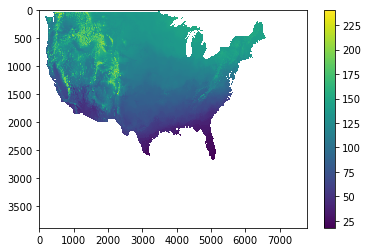

In [129]:
plotMatrix(dataSetBloomImputed[:, 0], maskFlattened, maskShape)

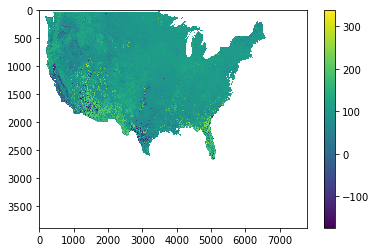

In [130]:
plotMatrix(dataSetSosImputed[:, 0], maskFlattened, maskShape)

In [131]:
structuredMatrixBloom = structureMatrix(dataSetBloomImputed[:, 0], maskFlattened, maskShape)
squareSubMatrixBloom = structuredMatrixBloom[900:1900, 1500:2500]

In [132]:
structuredMatrixSos = structureMatrix(dataSetSosImputed[:, 0], maskFlattened, maskShape)
squareSubMatrixSos = structuredMatrixSos[900:1900, 1500:2500]

Estimated Alpha: -1.378 | r^2: 0.530
Estimated Beta: -7.227 | r^2: 1.000
g.g: 3.979 | g.p_sim_g: 0.001
mi.I: 0.996 | mi.p_rand: 0.000


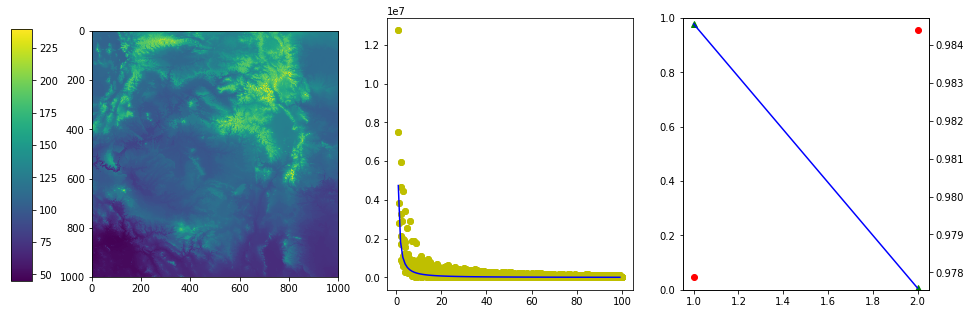

In [133]:
data = squareSubMatrixBloom
size = 1000
wavesMasked, fftMasked = getGaussianPowerSpectrum(data)
estimatedAlpha, estimatedIntercept, estimatedRSquared = estimateGaussianPowerLaw(data, wavesMasked, fftMasked)
U, s, Vt = scipy.linalg.svd(data, full_matrices = False)
x, valueList, cumulativeList = explainedVariance(s)
estimatedBeta, estimatedBetaIntercept, estimatedBetaRSquared = estimateSingularValuesPowerLaw(valueList)
y = data.flatten()
w = pysal.lat2W(size, size)
g = pysal.Gamma(y, w, standardize="yes")
mi = pysal.Moran(y, w)
print("Estimated Alpha: {:0.3f} | r^2: {:0.3f}".format(estimatedAlpha, estimatedRSquared))
print("Estimated Beta: {:0.3f} | r^2: {:0.3f}".format(estimatedBeta, estimatedBetaRSquared))
print("g.g: {:0.3f} | g.p_sim_g: {:0.3f}".format(g.g/size**2, g.p_sim_g))
print("mi.I: {:0.3f} | mi.p_rand: {:0.3f}".format(mi.I, mi.p_rand))
fig, (ax1, ax2, ax3) = matplotlib.pyplot.subplots(1, 3, figsize=(15, 5))
im = ax1.imshow(data)
cbaxes = fig.add_axes([0.05, 0.15, 0.02, 0.7])
fig.colorbar(im, cax = cbaxes)
ax2.plot(wavesMasked[wavesMasked<100], fftMasked[wavesMasked<100], "yo")
ax2.plot(range(1, 100), math.exp(estimatedIntercept) * numpy.power(range(1, 100), estimatedAlpha), "b-")
ax3.plot(x, valueList, "g^")
ax3.plot(x, math.exp(estimatedBetaIntercept) * numpy.power(x, estimatedBeta), "b-")
ax3.set_ylim(0, valueList[0])
ax3b = ax3.twinx()
ax3.set_ylim(0, 1)
ax3b.plot(x, cumulativeList, "ro")
matplotlib.pyplot.show()

Estimated Alpha: -0.607 | r^2: 0.185
Estimated Beta: -6.529 | r^2: 1.000
g.g: 2.380 | g.p_sim_g: 0.001
mi.I: 0.596 | mi.p_rand: 0.000


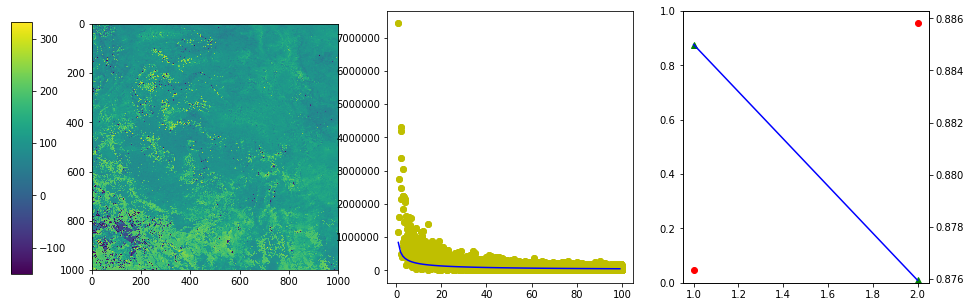

In [134]:
data = squareSubMatrixSos
size = 1000
wavesMasked, fftMasked = getGaussianPowerSpectrum(data)
estimatedAlpha, estimatedIntercept, estimatedRSquared = estimateGaussianPowerLaw(data, wavesMasked, fftMasked)
U, s, Vt = scipy.linalg.svd(data, full_matrices = False)
x, valueList, cumulativeList = explainedVariance(s)
estimatedBeta, estimatedBetaIntercept, estimatedBetaRSquared = estimateSingularValuesPowerLaw(valueList)
y = data.flatten()
w = pysal.lat2W(size, size)
g = pysal.Gamma(y, w, standardize="yes")
mi = pysal.Moran(y, w)
print("Estimated Alpha: {:0.3f} | r^2: {:0.3f}".format(estimatedAlpha, estimatedRSquared))
print("Estimated Beta: {:0.3f} | r^2: {:0.3f}".format(estimatedBeta, estimatedBetaRSquared))
print("g.g: {:0.3f} | g.p_sim_g: {:0.3f}".format(g.g/size**2, g.p_sim_g))
print("mi.I: {:0.3f} | mi.p_rand: {:0.3f}".format(mi.I, mi.p_rand))
fig, (ax1, ax2, ax3) = matplotlib.pyplot.subplots(1, 3, figsize=(15, 5))
im = ax1.imshow(data)
cbaxes = fig.add_axes([0.05, 0.15, 0.02, 0.7])
fig.colorbar(im, cax = cbaxes)
ax2.plot(wavesMasked[wavesMasked<100], fftMasked[wavesMasked<100], "yo")
ax2.plot(range(1, 100), math.exp(estimatedIntercept) * numpy.power(range(1, 100), estimatedAlpha), "b-")
ax3.plot(x, valueList, "g^")
ax3.plot(x, math.exp(estimatedBetaIntercept) * numpy.power(x, estimatedBeta), "b-")
ax3.set_ylim(0, valueList[0])
ax3b = ax3.twinx()
ax3.set_ylim(0, 1)
ax3b.plot(x, cumulativeList, "ro")
matplotlib.pyplot.show()

In [135]:
_ = gc.collect()

### Efficient SVD via Spatial Coarsening

Text

#### Single Spatial Field via Spatial Coarsening

Text

In [136]:
def calculateSingleSpatialFieldViaCoarsening(matrix, level=4, p=4):
    coarsenedMatrix = coarsenMatrix(matrix, level)
    coarsenedMatrixReduced = reduceMatrix(coarsenedMatrix, p)
    uncoarsenedMatrix = uncoarsenMatrix(coarsenedMatrixReduced, level)
    matrixReduced = reduceMatrix(matrix, p)
    return scipy.linalg.norm(uncoarsenedMatrix - matrixReduced) / scipy.linalg.norm(matrixReduced)

Text

In [137]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixBloom)

0.0061095006461294359

Text

In [138]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixBloom, level=2)

0.0029784781205488831

In [139]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixBloom, level=8)

0.011483692748974358

Text

In [140]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixBloom, p=2)

0.004444908432042166

In [141]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixBloom, p=8)

0.0086367232342150907

Text

In [142]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixSos)

0.0395205679197283

Text

In [143]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixSos, level=2)

0.026131087039017783

In [144]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixSos, level=8)

0.065994665407520817

Text

In [145]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixSos, p=2)

0.025025424961733839

In [146]:
calculateSingleSpatialFieldViaCoarsening(squareSubMatrixSos, p=8)

0.054030265773612723

In [147]:
_ = gc.collect()

#### Product of Spatial-Temporal Fields via Spatial Coarsening

Text

In [148]:
def uncoarsenMatrix3D(array, level):
    h, w, d = array.shape
    uncoarsenedMatrix3D = numpy.empty((h * level, w * level, d))
    for i in range(d):
        uncoarsenedMatrix3D[:, :, i] = uncoarsenMatrix(array[:, :, i], level)
    return uncoarsenedMatrix3D

In [149]:
def calculateProductSpatialTemporalFieldsViaCoarsening(matrixScaled1, matrixScaled2, maskFlattened, maskShape, level=4, modes=8):
    U, s, Vt = qrProductSVD(matrixScaled1, matrixScaled2)
    U, s, Vt = reduceUSV(U, s, Vt, modes)
    maskStructured = structureMatrix(maskFlattened[maskFlattened], maskFlattened, maskShape)
    maskCoarsened = ~numpy.isnan(coarsenMatrix(maskStructured, level)).flatten()
    matrixCoarsened1 = coarsenMatrix3D(structureMatrix3D(matrixScaled1, maskFlattened, maskShape), level)
    matrixCoarsened2 = coarsenMatrix3D(structureMatrix3D(matrixScaled2, maskFlattened, maskShape), level)
    matrixCoarsened1, matrixCoarsened2 = flattenSpatialTemporalFields(matrixCoarsened1, matrixCoarsened2)
    matrixCoarsened1 = matrixCoarsened1[maskCoarsened]
    matrixCoarsened2 = matrixCoarsened2[maskCoarsened]
    U2, s2, Vt2 = qrProductSVD(matrixCoarsened1, matrixCoarsened2)
    U2Restructured = structureMatrix3D(U2, maskCoarsened, (maskShape[0] // level, maskShape[1] // level))
    U2Uncoarsened = uncoarsenMatrix3D(U2Restructured, level)
    U2Uncoarsened = U2Uncoarsened.reshape(maskShape[0] * maskShape[1], U2Restructured.shape[2])[maskFlattened] / level
    V2Restructured = structureMatrix3D(Vt2.T, maskCoarsened, (maskShape[0] // level, maskShape[1] // level))
    V2Uncoarsened = uncoarsenMatrix3D(V2Restructured, level)
    V2Uncoarsened = V2Uncoarsened.reshape(maskShape[0] * maskShape[1], U2Restructured.shape[2])[maskFlattened] / level
    s2Uncoarsened = s2 * level**2
    U2, s2, Vt2 = reduceUSV(U2Uncoarsened, s2Uncoarsened, V2Uncoarsened.T, modes)
    return percentageNormDifferenceFromUSVs(U, s, Vt, U2, s2, Vt2)

Text

In [150]:
calculateProductSpatialTemporalFieldsViaCoarsening(dataSetBloomScaled, dataSetSosScaled, maskFlattened, maskShape, level=4, modes=8)

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


0.5208015054523247

In [151]:
_ = gc.collect()

Text

In [152]:
calculateProductSpatialTemporalFieldsViaCoarsening(dataSetBloomScaled, dataSetSosScaled, maskFlattened, maskShape, level=2, modes=8)

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


0.4257772943508524

In [153]:
_ = gc.collect()

Text

In [154]:
calculateProductSpatialTemporalFieldsViaCoarsening(dataSetBloomScaled, dataSetSosScaled, maskFlattened, maskShape, level=4, modes=4)

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


0.5012619952670825

In [155]:
_ = gc.collect()

### Efficient SVD via Randomised Dimensionality Reduction

Text

#### Single Spatial Field via Randomised Dimensionality Reduction

Text

In [156]:
def calculateRandomisedSizeReducedMatrix(matrix, level=4, i=1, modes=8):
    H, L, W = reduceSizeRandomisedSquare(matrix, i, matrix.shape[0] // level)
    LReduced = reduceMatrix(L, modes)
    reconstructedmatrix = reconstructSquareRandomisedSizeReducedMatrix(H, LReduced, W)
    matrixReduced = reduceMatrix(matrix, modes)
    return scipy.linalg.norm(reconstructedmatrix - matrixReduced) / scipy.linalg.norm(matrixReduced)

Text

In [157]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixBloom)

1.0511138802096567e-06

Text

In [158]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixBloom, level=2)

6.8272120448596751e-08

In [159]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixBloom, level=8)

1.026663434281697e-05

Text

In [160]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixBloom, i=0)

0.0025210414516147273

In [161]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixBloom, i=2)

8.6077245797640201e-10

Text

In [162]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixBloom, modes=4)

2.5190123310672504e-07

In [163]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixBloom, modes=16)

5.2453860905577118e-06

Text

In [164]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixSos)

0.00096974419022781747

Text

In [165]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixSos, level=2)

9.0945885566653216e-05

In [166]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixSos, level=8)

0.0034270572667065638

Text

In [167]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixSos, i=0)

0.034318025569302683

In [168]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixSos, i=2)

3.1391993185875432e-05

Text

In [169]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixSos, modes=4)

0.00040346967110173809

In [170]:
calculateRandomisedSizeReducedMatrix(squareSubMatrixSos, modes=16)

0.0023167642605716869

Text

In [171]:
_ = gc.collect()

#### Product of Spatial-Temporal Fields via Randomised Dimensionality Reduction

Text

In [172]:
def calculateRandomisedSizeReducedMatrixProduct(matrixScaled1, matrixScaled2, level=4, i=1, modes=8):
    U, s, Vt = qrProductSVD(matrixScaled1, matrixScaled2)
    U, s, Vt = reduceUSV(U, s, Vt, min(modes, temporalSize // level))
    U2, s2, Vt2 = randomisedSquareProductSVD(matrixScaled1, matrixScaled2, i, temporalSize // level)
    U2, s2, Vt2 = reduceUSV(U2, s2, Vt2, min(modes, temporalSize // level))
    return percentageNormDifferenceFromUSVs(U, s, Vt, U2, s2, Vt2)

Text

In [173]:
calculateRandomisedSizeReducedMatrixProduct(dataSetBloomScaled, dataSetSosScaled)

0.4835292186252892

In [174]:
_ = gc.collect()

Text

In [175]:
calculateRandomisedSizeReducedMatrixProduct(dataSetBloomScaled, dataSetSosScaled, level=2)

0.22205873483522684

In [176]:
_ = gc.collect()

In [177]:
calculateRandomisedSizeReducedMatrixProduct(dataSetBloomScaled, dataSetSosScaled, level=8)

0.6389907403582945

In [178]:
_ = gc.collect()

Text

In [179]:
calculateRandomisedSizeReducedMatrixProduct(dataSetBloomScaled, dataSetSosScaled, i=0)

0.7169818302382186

In [180]:
_ = gc.collect()

In [181]:
calculateRandomisedSizeReducedMatrixProduct(dataSetBloomScaled, dataSetSosScaled, i=2)

0.4481522644466678

In [182]:
_ = gc.collect()

Text

In [183]:
calculateRandomisedSizeReducedMatrixProduct(dataSetBloomScaled, dataSetSosScaled, modes=4)

0.4536945792622755

In [184]:
_ = gc.collect()

In [185]:
calculateRandomisedSizeReducedMatrixProduct(dataSetBloomScaled, dataSetSosScaled, modes=16)

0.5074567444743656

In [186]:
_ = gc.collect()

## Unsuccessful Techniques

The following two techniques to perform an SVD in an efficient manner were investigated but were deemed unreliable.

### Efficient SVD via Grid Analysis

Text

#### Single Spatial Field via Single Grid

Text

In [ ]:
def testSVDByGrid(size=200, alpha=-2, nrows=20, ncols=20, p=2):
    matrix = gaussianRandomSpatialField(alpha=alpha, size=size)
    matrixGrid = matrixToGrid(matrix, nrows, ncols)
    gridElementsReduced = []
    for gridElement in matrixGrid:
        gridElementsReduced.append(reduceMatrix(gridElement, p))
    matrixReconstructed = gridToMatrix(numpy.array(gridElementsReduced))
    matrixReduced = reduceMatrix(matrix, p)
    return scipy.linalg.norm(matrixReconstructed - matrixReduced) / scipy.linalg.norm(matrixReduced)

Text

In [ ]:
matrix = gaussianRandomSpatialField()
matrixGrid = matrixToGrid(matrix, 20, 20)
gridElementsReduced = []
for gridElement in matrixGrid:
    gridElementsReduced.append(reduceMatrix(gridElement, 1))
matrixReconstructed = gridToMatrix(numpy.array(gridElementsReduced))
matrixReduced = reduceMatrix(matrix, 1)
matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 4, 1)
matplotlib.pyplot.imshow(matrixReduced)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 2)
matplotlib.pyplot.imshow(matrixReconstructed)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 3)
matplotlib.pyplot.imshow(matrixReconstructed - matrixReduced)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 4)
matplotlib.pyplot.imshow(numpy.abs(matrixReconstructed - matrixReduced))
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.show()
print(scipy.linalg.norm(matrixReduced))
print(scipy.linalg.norm(matrixReconstructed))
print(scipy.linalg.norm(matrixReconstructed - matrixReduced))

Text

In [ ]:
loop(testSVDByGrid)

In [ ]:
loop(testSVDByGrid, {"size": 100})

In [ ]:
loop(testSVDByGrid, {"size": 400})

In [ ]:
loop(testSVDByGrid, {"nrows": 10, "ncols": 10})

In [ ]:
loop(testSVDByGrid, {"nrows": 40, "ncols": 40})

In [ ]:
loop(testSVDByGrid, {"alpha": -1})

In [ ]:
loop(testSVDByGrid, {"alpha": -4})

In [ ]:
loop(testSVDByGrid, {"p": 1})

In [ ]:
loop(testSVDByGrid, {"p": 4})

#### Product of Spatial-Temporal Fields via Single Grid

Text

In [ ]:
def matrixToGrid3D(array, gridSize):
    h, w, d = array.shape
    if h % gridSize > 0 or w % gridSize > 0:
        print("Shape does not fit")
        return []
    return array.reshape(h//gridSize, gridSize, -1, gridSize, d).swapaxes(1, 2).reshape(-1, gridSize, gridSize, d)

Text

In [ ]:
def gridToMatrix3D(gridElements):
    widthSquared, nrows, ncols, d = gridElements.shape
    width = math.sqrt(widthSquared)
    if width % 1 > 0:
        print("Shape does not fit")
        return []
    width = int(width)
    return gridElements.swapaxes(0, 1).reshape(nrows, -1, width * ncols, d).swapaxes(0, 1).reshape(width * nrows, width * ncols, d)

Text

In [ ]:
spatialSize=100
temporalSize=40
alpha=-2
gridSize=50
number=0
matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
matrixSplit1, matrixSplit2 = splitSpatialTemporalField(matrixCombined)
matrixFlattened1, matrixFlattened2 = flattenSpatialTemporalFields(matrixSplit1, matrixSplit2)
U, s, Vt = qrProductSVD(matrixFlattened1, matrixFlattened2)
UReshaped = U.reshape(spatialSize, spatialSize, temporalSize)
UReshapedExpectedGrid = matrixToGrid3D(UReshaped, gridSize)
matrixGrid1 = matrixToGrid3D(matrixSplit1, gridSize)
matrixGrid2 = matrixToGrid3D(matrixSplit2, gridSize)
gridElementsU = []
for i in range(len(matrixGrid1)):
    matrixFlattenedGrid1, matrixFlattenedGrid2 = flattenSpatialTemporalFields(matrixGrid1[i], matrixGrid2[i])
    UGrid, sGrid, VtGrid = qrProductSVD(matrixFlattenedGrid1, matrixFlattenedGrid2)
    UGridReshaped = UGrid.reshape(gridSize, gridSize, temporalSize)
    sign = []
    for j in range(temporalSize):
        if scipy.linalg.norm(UReshapedExpectedGrid[i, :, :, j] - UGridReshaped[:, :, j]) > scipy.linalg.norm(UReshapedExpectedGrid[i, :, :, j] + UGridReshaped[:, :, j]):
            sign.append(-1)
        else:
            sign.append(1)
    gridElementsU.append(UGridReshaped @ numpy.diag(sign))
UReshaped2 = gridToMatrix3D(numpy.array(gridElementsU))
matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 4, 1)
matplotlib.pyplot.imshow(UReshaped[:, :, number])
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 2)
matplotlib.pyplot.imshow(UReshaped2[:, :, number])
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 3)
matplotlib.pyplot.imshow(UReshaped[:, :, number] - UReshaped2[:, :, number])
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 4)
matplotlib.pyplot.imshow(numpy.abs(UReshaped[:, :, number] - UReshaped2[:, :, number]))
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.show()
print(scipy.linalg.norm(UReshaped[:, :, number]))
print(scipy.linalg.norm(UReshaped2[:, :, number]))
print(scipy.linalg.norm(UReshaped2[:, :, number] - UReshaped[:, :, number]))

Text

In [ ]:
def testProductSVDByGrid(spatialSize=200, temporalSize=40, alpha=-2, gridSize=20, number=0):
    matrixCombined = gaussianRandomSpatialTemporalField(alpha, spatialSize, 2*temporalSize)
    matrixSplit1, matrixSplit2 = splitSpatialTemporalField(matrixCombined)
    matrixFlattened1, matrixFlattened2 = flattenSpatialTemporalFields(matrixSplit1, matrixSplit2)
    U, s, Vt = qrProductSVD(matrixFlattened1, matrixFlattened2)
    UReshaped = U.reshape(spatialSize, spatialSize, temporalSize)
    UReshapedExpectedGrid = matrixToGrid3D(UReshaped, gridSize)
    matrixGrid1 = matrixToGrid3D(matrixSplit1, gridSize)
    matrixGrid2 = matrixToGrid3D(matrixSplit2, gridSize)
    gridElementsU = []
    for i in range(len(matrixGrid1)):
        matrixFlattenedGrid1, matrixFlattenedGrid2 = flattenSpatialTemporalFields(matrixGrid1[i], matrixGrid2[i])
        UGrid, sGrid, VtGrid = qrProductSVD(matrixFlattenedGrid1, matrixFlattenedGrid2)
        UGridReshaped = UGrid.reshape(gridSize, gridSize, temporalSize)
        sign = []
        for j in range(temporalSize):
            if scipy.linalg.norm(UReshapedExpectedGrid[i, :, :, j] - UGridReshaped[:, :, j]) > scipy.linalg.norm(UReshapedExpectedGrid[i, :, :, j] + UGridReshaped[:, :, j]):
                sign.append(-1)
            else:
                sign.append(1)
        gridElementsU.append(UGridReshaped @ numpy.diag(sign))
    UReshaped2 = gridToMatrix3D(numpy.array(gridElementsU))
    return scipy.linalg.norm(UReshaped2[:, :, number] - UReshaped[:, :, number]) / scipy.linalg.norm(UReshaped[:, :, number])

Text

In [ ]:
loop(testProductSVDByGrid)

In [ ]:
loop(testProductSVDByGrid, {"spatialSize": 100})

In [ ]:
loop(testProductSVDByGrid, {"temporalSize": 20})

In [ ]:
loop(testProductSVDByGrid, {"temporalSize": 100})

In [ ]:
loop(testProductSVDByGrid, {"gridSize": 10})

In [ ]:
loop(testProductSVDByGrid, {"gridSize": 50})

In [ ]:
loop(testProductSVDByGrid, {"alpha": -1})

In [ ]:
loop(testProductSVDByGrid, {"alpha": -4})

In [ ]:
loop(testProductSVDByGrid, {"number": 1})

In [ ]:
loop(testProductSVDByGrid, {"number": 2})

### Efficient SVD via Moving Grid Analysis

Text

#### Single Spatial Field via Moving Grid

Text

In [ ]:
def matrixToFourGrids(dataArray, gridSize):
    halfGridSize = gridSize // 2
    arrayHeight, arrayWidth = dataArray.shape
    if (arrayHeight - halfGridSize) % halfGridSize > 0 or (arrayWidth - halfGridSize) % halfGridSize > 0:
        print("Shape does not fit")
        return []
    subArrays = [
        dataArray[:-halfGridSize, :-halfGridSize],
        dataArray[:-halfGridSize, halfGridSize:],
        dataArray[halfGridSize:, :-halfGridSize],
        dataArray[halfGridSize:, halfGridSize:]
    ]
    result = []
    for subArray in subArrays:
        result.append(matrixToGrid(subArray, gridSize, gridSize))
    return result

Text

In [ ]:
def fourGridsToMatrix(subArrays):
    gridHeight, gridWidth = subArrays[0][0].shape
    halfGridHeight = gridHeight // 2
    halfGridWidth = gridWidth // 2
    matrices = []
    for subArray in subArrays:
        matrices.append(gridToMatrix(subArray))
    meanUpper = (matrices[0][:, halfGridWidth:] + matrices[1][:, :-halfGridWidth]) / 2
    concatenatedUpper = numpy.concatenate((matrices[0][:, :halfGridWidth], meanUpper, matrices[1][:, -halfGridWidth:]), axis=1)
    meanLower = (matrices[2][:, halfGridWidth:] + matrices[3][:, :-halfGridWidth]) / 2
    concatenatedLower = numpy.concatenate((matrices[2][:, :halfGridWidth], meanLower, matrices[3][:, -halfGridWidth:]), axis=1)
    mean = (concatenatedUpper[halfGridHeight:, :] + concatenatedLower[:-halfGridHeight, :]) / 2
    result = numpy.concatenate((concatenatedUpper[:halfGridHeight, :], mean, concatenatedLower[-halfGridHeight:, :]), axis=0)
    return result

Text

In [ ]:
def testSVDByFourGrids(size=200, alpha=-2, gridSize=20, p=2):
    size = size - size % gridSize + gridSize // 2
    matrix = gaussianRandomSpatialField(alpha, size)
    matrixFourGrids = matrixToFourGrids(matrix, gridSize)
    subArrays = []
    for matrixGrid in matrixFourGrids:
        gridElementsReduced = []
        for gridElement in matrixGrid:
            gridElementsReduced.append(reduceMatrix(gridElement, p))
        subArrays.append(numpy.array(gridElementsReduced))
    matrixReconstructed = fourGridsToMatrix(subArrays)
    matrixReduced = reduceMatrix(matrix, p)
    return scipy.linalg.norm(matrixReconstructed - matrixReduced) / scipy.linalg.norm(matrixReduced)

Text

In [ ]:
matrix = gaussianRandomSpatialField(size=210)
matrixFourGrids = matrixToFourGrids(matrix, 20)
subArrays = []
for matrixGrid in matrixFourGrids:
    gridElementsReduced = []
    for gridElement in matrixGrid:
        gridElementsReduced.append(reduceMatrix(gridElement, 1))
    subArrays.append(numpy.array(gridElementsReduced))
matrixReconstructed = fourGridsToMatrix(subArrays)
matrixReduced = reduceMatrix(matrix, 1)
matplotlib.pyplot.figure(figsize=(20, 20))
matplotlib.pyplot.subplot(1, 4, 1)
matplotlib.pyplot.imshow(matrixReduced)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 2)
matplotlib.pyplot.imshow(matrixReconstructed)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 3)
matplotlib.pyplot.imshow(matrixReconstructed - matrixReduced)
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.subplot(1, 4, 4)
matplotlib.pyplot.imshow(numpy.abs(matrixReconstructed - matrixReduced))
matplotlib.pyplot.colorbar(fraction=0.05)
matplotlib.pyplot.show()
print(scipy.linalg.norm(matrixReduced))
print(scipy.linalg.norm(matrixReconstructed))
print(scipy.linalg.norm(matrixReconstructed - matrixReduced))

Text

In [ ]:
loop(testSVDByFourGrids)

In [ ]:
loop(testSVDByFourGrids, {"size": 100})

In [ ]:
loop(testSVDByFourGrids, {"size": 400})

In [ ]:
loop(testSVDByFourGrids, {"gridSize": 12})

In [ ]:
loop(testSVDByFourGrids, {"gridSize": 40})

In [ ]:
loop(testSVDByFourGrids, {"alpha": -1})

In [ ]:
loop(testSVDByFourGrids, {"alpha": -4})

In [ ]:
loop(testSVDByFourGrids, {"p": 1})

In [ ]:
loop(testSVDByFourGrids, {"p": 4})

End of _Jupyter Notebook_.